In [1]:
# import libraries
library(tidyverse)
library(caret)
library(corrplot)
library(reshape2)
library(gridExtra)
library(leaps)
library('ggpubr')
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'caret' was built under R version 4.3.2"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'corrplot' was built under R version 4.3.3"
corrplot 0.92 loaded

Warning message:
"package 'reshape2' was built under R version 4.3.2"

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching packag

# Data

In [2]:
# read in dataset
# from https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012
df <- read_csv('data/baseball.csv')

Rows: 1232 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Team, League
dbl (13): Year, RS, RA, W, OBP, SLG, BA, Playoffs, RankSeason, RankPlayoffs,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Functions

In [4]:
mspe_loop <- function(train_set, test_set, regsubset_summary, response) {
    # observed values from test set
    obs <- test_set[[response]]
    # initialize mspe tracking list
    mspe_results <- c()
    loop_size <- dim(regsubset_summary$which)[1]
    for (model in 1:loop_size) {
        # create model
        true_cols <- names(which(regsubset_summary$which[model,]))
        # remove intercept feature
        true_cols <- true_cols[true_cols != '(Intercept)']
        formula <- paste(unlist(true_cols), collapse = '+')
        formula <- paste('~', formula, '')
        formula <- paste(response, formula, '')
        lmod <- lm(data = train_set, as.formula(formula))
        # calculate MSPE
        preds <- lmod %>% predict(test_set)
        mspe <- mean((obs - preds)^2)
        mspe_results <- c(mspe_results, mspe)
    }
    return(mspe_results)
}

In [5]:
# function for making dataframe long with respect to response variable
create_long_df <- function(df, response) {
    df_long <- pivot_longer(df,
                            cols = names(df %>% select(-all_of(response))),
                            names_to = 'feature_names',
                            values_to = 'feature_values')
    return(df_long)
}

In [6]:
# create function for faceted plots
plot_long_facets <- function(df_long, subset_type, response) {
    title_text <- paste(subset_type, response)
    ggplot(df_long, aes(x=feature_values, y=!!sym(response))) +
        geom_point() +
        facet_wrap(~ feature_names, scales = 'free_x') +
        ggtitle(title_text) +
        xlab('Feature')
}

In [7]:
# create function to automate the plotting
plot_mlr <- function(full_set, train_set, test_set, response, subset_type) {
    # faceted plots
    # 1) build long dataframe with respect to variabe
    # 2) create plots
    df_long <- create_long_df(df=full_set, response=response)
    faceted_plots <- plot_long_facets(df_long=df_long, subset_type=subset_type, response=response)
    print(faceted_plots)
    
    # regsubsets builds models with forward selection
    formula <- paste(response, '~.', '')
    reg_lm <- regsubsets(data=train_set, as.formula(formula))
    rs <- summary(reg_lm)
    print(rs$which)
    
    # compute dimensions from dataset
    n <- dim(train_set)[1]
    m <- dim(train_set)[2]
    x <- 1:(m-1)

    # compute metrics
    AIC <- 2*(2:m) + n*log(rs$rss/n)
    BIC <- log(n)*(2:m) + n*log(rs$rss/n)
    R2Adj <- rs$adjr2
    mspe <- mspe_loop(train_set=train_set, test_set=test_set, regsubset_summary=rs, response=response)

    # turn metrics into dataframes
    AIC_df <- data.frame(AIC = AIC)
    BIC_df <- data.frame(BIC = BIC)
    R2Adj_df <- data.frame(R2Adj = R2Adj)
    mspe_df <- data.frame(MSPE = mspe)
    
    # AIC Plot
    AIC_plot <- ggplot(data = AIC_df, aes(x=x, y=AIC)) +
        geom_line() +
        geom_point(aes(x=which.min(AIC), y=min(AIC)), color='red', size=3) +
        xlab('Model')

    # BIC Plot
    BIC_plot <- ggplot(data = BIC_df, aes(x=x, y=BIC)) +
        geom_line() +
        geom_point(aes(x=which.min(BIC), y=min(BIC)), color='red', size=3) +
        xlab('Model')

    # Adjusted R2 Plot
    R2Adj_plot <- ggplot(data = R2Adj_df, aes(x=x, y=R2Adj)) +
        geom_line() +
        geom_point(aes(x=which.max(R2Adj), y=max(R2Adj)), color='red', size=3) +
        xlab('Model')

    # MSPE Plot
    MSPE_plot <- ggplot(data = mspe_df, aes(x=x, y=MSPE)) +
        geom_line() +
        geom_point(aes(x=which.min(mspe), y=min(mspe)), color='red', size=3) +
        xlab('Model')
    
    # combine plots
    combined_plot <- ggarrange(AIC_plot, BIC_plot, R2Adj_plot, MSPE_plot,
                           labels = c('AIC', 'BIC', 'R2Adj', 'MSPE'))
    
    print(combined_plot)
}

In [48]:
diagnostics_plots <- function(df, model, response_var, type='linear') {
    # default plots
    plot(model)
    
    # if linear
    if (type=='linear') {
        plot(predict(model), df[[response_var]])
    # if response
    } else  if (type=='response') {
        plot(predict(model, type='response'), df[[response_var]])
    } else {
        print('Please use either type: linear or type: response')
    }
    
    
    # successive residuals
    df_diagnostics = data.frame(yhat = fitted(model), r = resid(model), y = df[[response_var]])

    n = dim(df)[1]; 
    x = head(df_diagnostics$r, n-1)
    y = tail(df_diagnostics$r, n-1)
    srp = data.frame(x,y)
    ggplot(srp, aes(x = x, y = y)) + 
        geom_point() + 
        geom_vline(xintercept = 0) + 
        geom_hline(yintercept = 0) + 
        xlab(expression(hat(epsilon)[i])) +
        ylab(expression(hat(epsilon)[i+1])) + 
        ggtitle("Successive Residual Plot") + 
        theme_bw() + 
        theme(plot.title = element_text(hjust = 0.5)) 
    }

# Clean Data

In [3]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
# print(col_na)
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
# print(break_na)
# summarize break_na
summary(break_na)
season_break <- max(break_na)
# print(season_break)

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

In [4]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [5]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [6]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [7]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [8]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [9]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

In [10]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
# print(col_na)
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
# print(break_na)
# summarize break_na
summary(break_na)
season_break <- max(break_na)
# print(season_break)

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

In [11]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [12]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [13]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [14]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [15]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [16]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

In [17]:
# full dataset for modeling
df_full_mlr <- df_full %>% select(-c(Year, League))
# recent dataset for modeling
df_recent_mlr <- df_recent %>% select(-c(Year, League))

In [19]:
# write.csv(df_full_mlr, "baseball_cleaned.csv", row.names = FALSE)

In [23]:
# train/test split for full data
set.seed(42)
n = floor(0.8 * nrow(df_full_mlr)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_full_mlr)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_full = df_full_mlr[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full = df_full_mlr[-index, ] #set the testing set to be the remaining rows

In [24]:
# train/test split for recent data
set.seed(42)
n = floor(0.8 * nrow(df_recent_mlr)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_recent_mlr)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_recent = df_recent_mlr[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent = df_recent_mlr[-index, ] #set the testing set to be the remaining rows

# Model Selection

  (Intercept)   OBP   SLG    BA   RD Playoffs Champion
1        TRUE FALSE FALSE FALSE TRUE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE TRUE     TRUE    FALSE
3        TRUE FALSE FALSE FALSE TRUE     TRUE     TRUE
4        TRUE FALSE FALSE  TRUE TRUE     TRUE     TRUE
5        TRUE  TRUE FALSE  TRUE TRUE     TRUE     TRUE
6        TRUE  TRUE  TRUE  TRUE TRUE     TRUE     TRUE


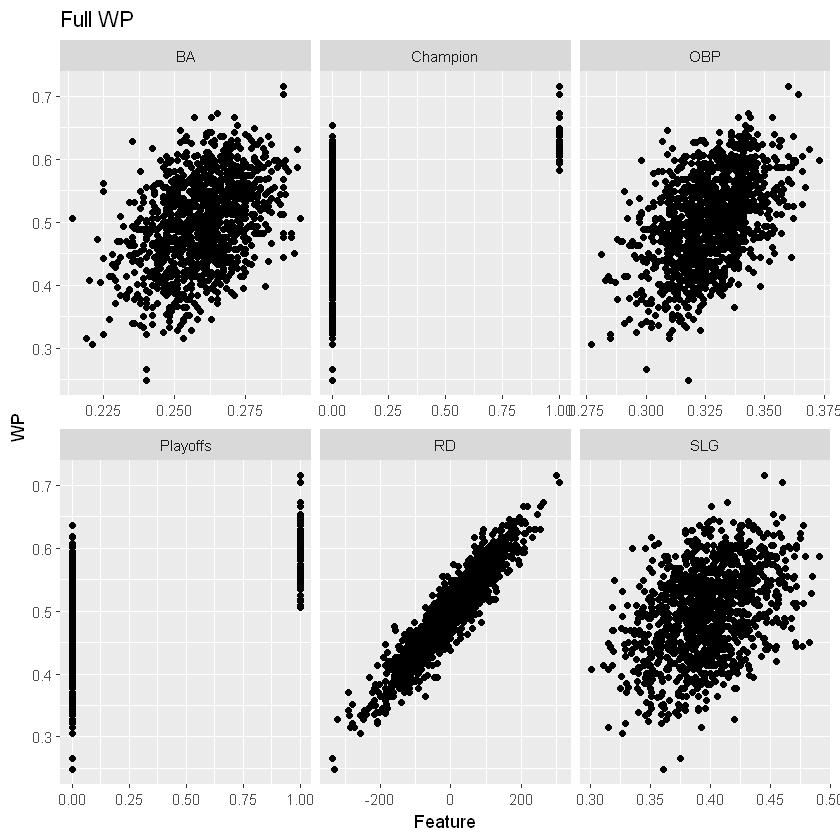

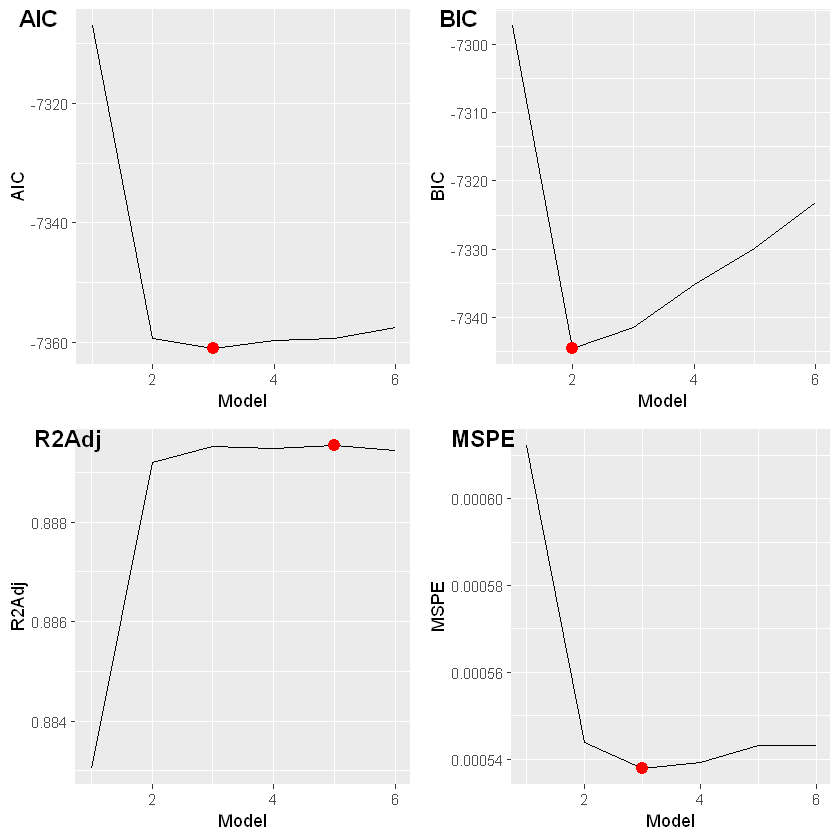

In [26]:
# full data - winning percentage (WP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_full_mlr, train_set=train_full, test_set=test_full, response='WP', subset_type='Full')

## Full Dataset - WP

- AIC reports Model 3 as the best model (minimum)
- BIC reports Model 2 as the best model (minimum)
- $R^2_a$ reports model 5 as the best model (maximum)
- MSPE reports model 3 asthe best model

We have two metrics alluding to Model 3 being the best model to describe the response, and although the other metrics report different best models, the results for Model 3 in those metrics are close. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- RD
- Playoffs
- Champion

In [32]:
lmod <- lm(data=train_full, WP~.)
lmod_full_wp <- lm(data=train_full, WP~RD+Playoffs+Champion)
summary(lmod_full_wp)
anova(lmod_full_wp, lmod)


Call:
lm(formula = WP ~ RD + Playoffs + Champion, data = train_full)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.088287 -0.015903  0.000351  0.016539  0.076162 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.961e-01  8.949e-04 554.372  < 2e-16 ***
RD          6.061e-04  9.093e-06  66.654  < 2e-16 ***
Playoffs    1.614e-02  2.405e-03   6.713 3.23e-11 ***
Champion    8.332e-03  4.309e-03   1.934   0.0535 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02379 on 981 degrees of freedom
Multiple R-squared:  0.8899,	Adjusted R-squared:  0.8895 
F-statistic:  2642 on 3 and 981 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,981,0.5551140,NA,NA,NA,NA
2,978,0.5537638,3,0.001350184,0.7948516,0.4968315


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

  (Intercept)   SLG   BA    WP    RD Playoffs Champion
1        TRUE FALSE TRUE FALSE FALSE    FALSE    FALSE
2        TRUE  TRUE TRUE FALSE FALSE    FALSE    FALSE
3        TRUE  TRUE TRUE  TRUE FALSE    FALSE    FALSE
4        TRUE  TRUE TRUE  TRUE FALSE    FALSE     TRUE
5        TRUE  TRUE TRUE  TRUE  TRUE    FALSE     TRUE
6        TRUE  TRUE TRUE  TRUE  TRUE     TRUE     TRUE


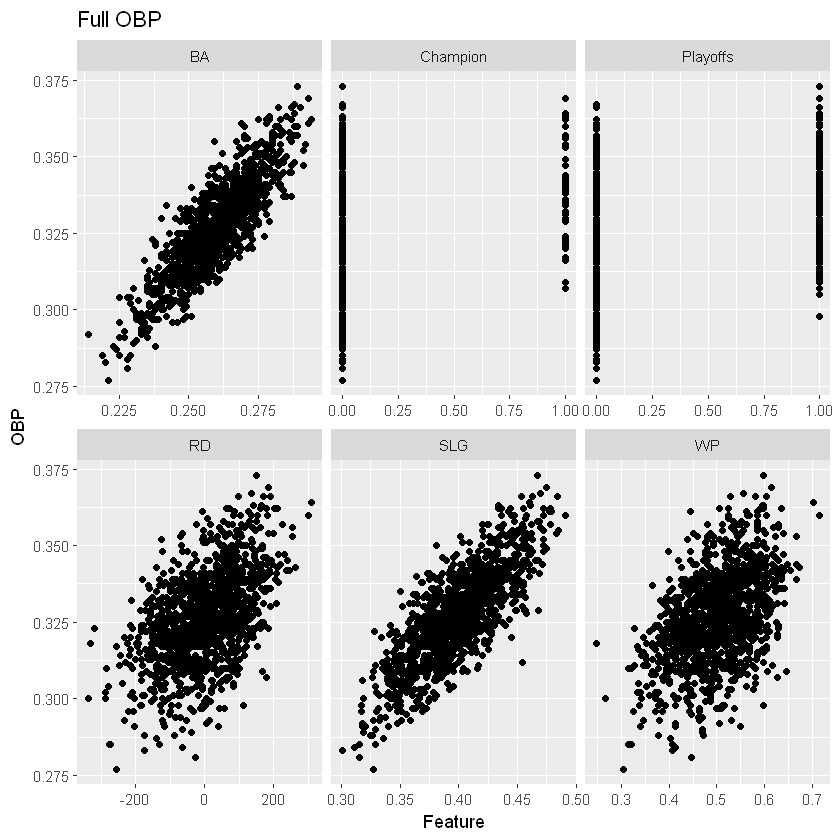

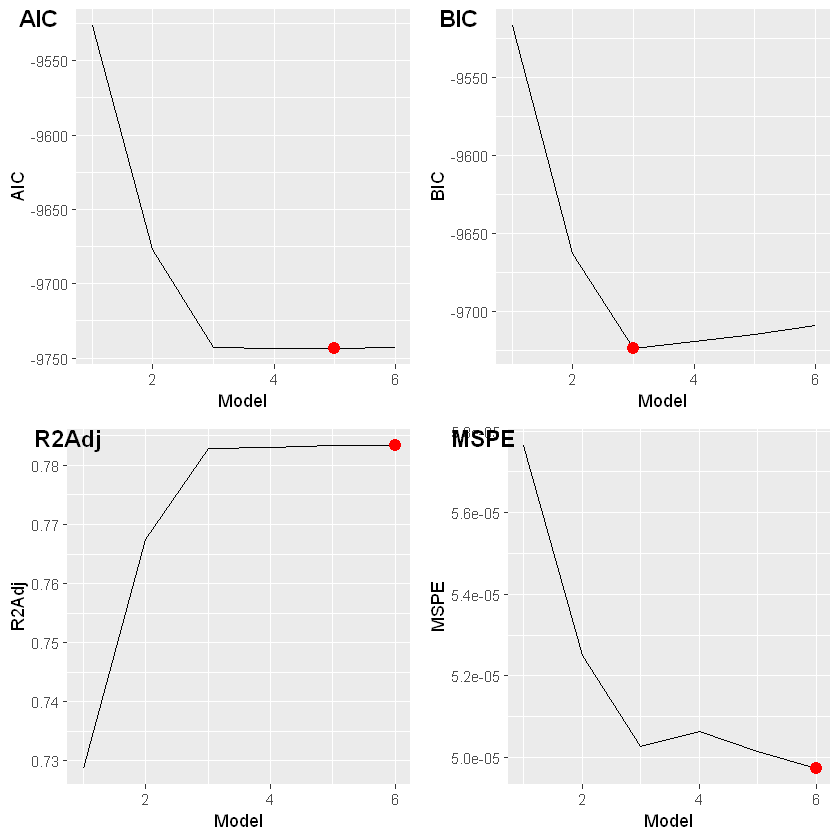

In [27]:
# full data - on-base percentage (OBP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_full_mlr, train_set=train_full, test_set=test_full, response='OBP', subset_type='Full')

## Full Dataset - OBP

- AIC reports Model 5 as the best model (minimum)
- BIC reports Model 3 as the best model (minimum)
- $R^2_a$ reports model 6 as the best model (maximum)
- MSPE reports model 6 as the best model

We have two metrics alluding to Model 6 being the best model to describe the response, and for the metrics that don't allude to this being the best, their best are relatively close for Model 3 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- SLG
- BA
- WP

In [34]:
lmod <- lm(data=train_full, OBP~.)
lmod_full_obp <- lm(data=train_full, OBP~SLG+BA+WP)
summary(lmod_full_obp)
anova(lmod_full_obp, lmod)


Call:
lm(formula = OBP ~ SLG + BA + WP, data = train_full)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0196243 -0.0048779 -0.0001481  0.0048063  0.0238899 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.085607   0.004763  17.974   <2e-16 ***
SLG         0.133661   0.011164  11.972   <2e-16 ***
BA          0.667557   0.028847  23.141   <2e-16 ***
WP          0.029312   0.003503   8.368   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007099 on 981 degrees of freedom
Multiple R-squared:  0.7834,	Adjusted R-squared:  0.7828 
F-statistic:  1183 on 3 and 981 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,981,0.04944351,NA,NA,NA,NA
2,978,0.04915107,3,0.0002924418,1.939653,0.1215094


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

  (Intercept)  OBP    BA    WP    RD Playoffs Champion
1        TRUE TRUE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE TRUE  TRUE FALSE FALSE    FALSE    FALSE
3        TRUE TRUE  TRUE FALSE FALSE     TRUE    FALSE
4        TRUE TRUE  TRUE  TRUE FALSE     TRUE    FALSE
5        TRUE TRUE  TRUE  TRUE FALSE     TRUE     TRUE
6        TRUE TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


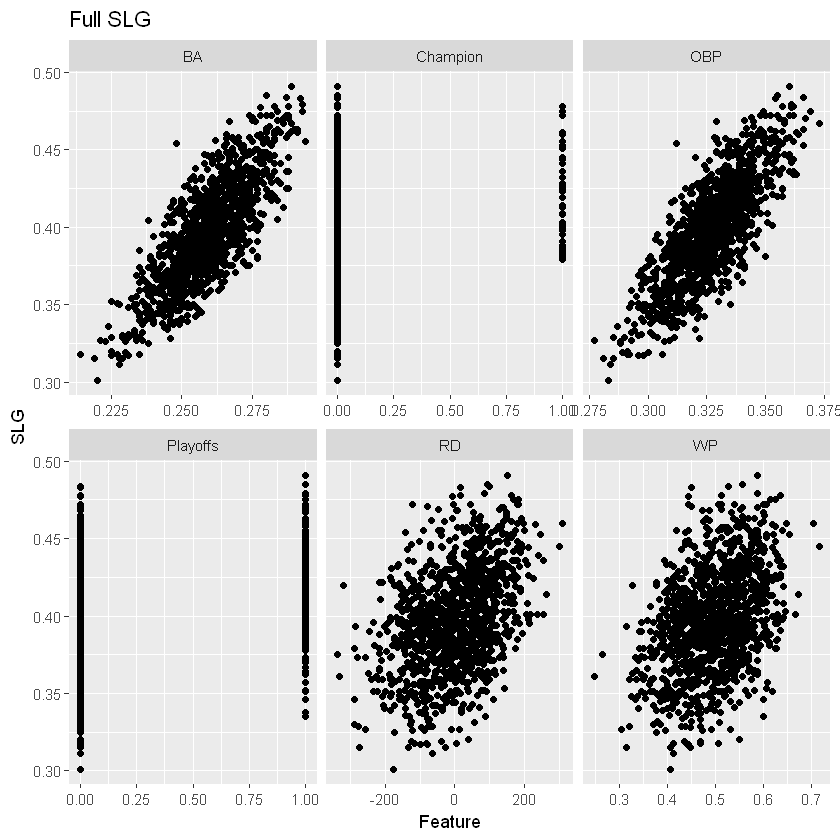

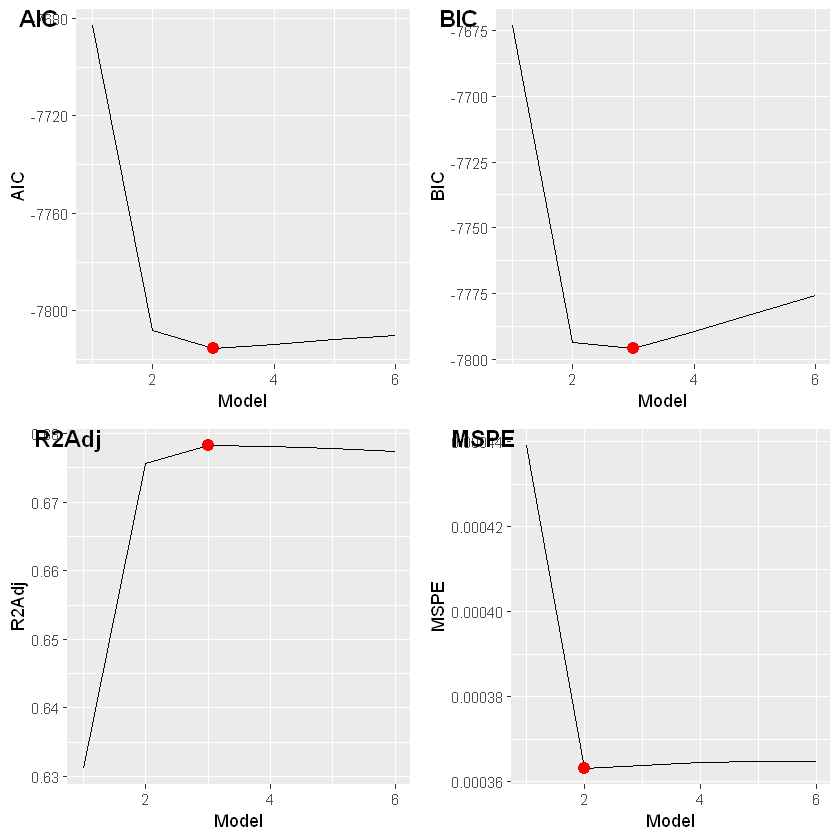

In [28]:
# full data - slugging percentage (SLG)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_full_mlr, train_set=train_full, test_set=test_full, response='SLG', subset_type='Full')

## Full Dataset - SLG

- AIC reports Model 3 as the best model (minimum)
- BIC reports Model 3 as the best model (minimum)
- $R^2_a$ reports model 3 as the best model (maximum)
- MSPE reports model 2 as the best model

We have three metrics alluding to Model 3 being the best model to describe the response, and the metric that doesn't allude to this being the best, their best is relatively close for Model 3 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- OBP
- BA
- Playoffs

In [35]:
lmod <- lm(data=train_full, SLG~.)
lmod_full_slg <- lm(data=train_full, SLG~OBP+BA+Playoffs)
summary(lmod_full_obp)
anova(lmod_full_slg, lmod)


Call:
lm(formula = OBP ~ SLG + BA + WP, data = train_full)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0196243 -0.0048779 -0.0001481  0.0048063  0.0238899 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.085607   0.004763  17.974   <2e-16 ***
SLG         0.133661   0.011164  11.972   <2e-16 ***
BA          0.667557   0.028847  23.141   <2e-16 ***
WP          0.029312   0.003503   8.368   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.007099 on 981 degrees of freedom
Multiple R-squared:  0.7834,	Adjusted R-squared:  0.7828 
F-statistic:  1183 on 3 and 981 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,981,0.3499427,NA,NA,NA,NA
2,978,0.3497889,3,0.0001538251,0.1433636,0.9339322


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

  (Intercept)   OBP   SLG    BA   RD  OOBP  OSLG Playoffs Champion
1        TRUE FALSE FALSE FALSE TRUE FALSE FALSE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE TRUE FALSE FALSE     TRUE    FALSE
3        TRUE FALSE FALSE FALSE TRUE  TRUE FALSE     TRUE    FALSE
4        TRUE FALSE  TRUE FALSE TRUE  TRUE FALSE     TRUE    FALSE
5        TRUE FALSE  TRUE FALSE TRUE  TRUE FALSE     TRUE     TRUE
6        TRUE FALSE  TRUE FALSE TRUE  TRUE  TRUE     TRUE     TRUE
7        TRUE  TRUE  TRUE FALSE TRUE  TRUE  TRUE     TRUE     TRUE
8        TRUE  TRUE  TRUE  TRUE TRUE  TRUE  TRUE     TRUE     TRUE


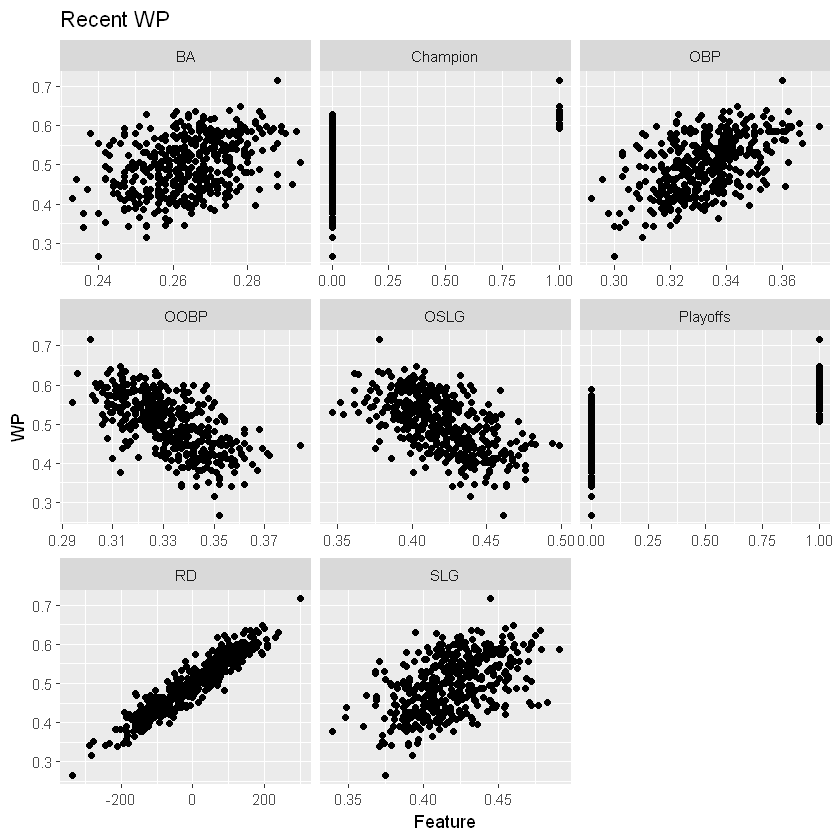

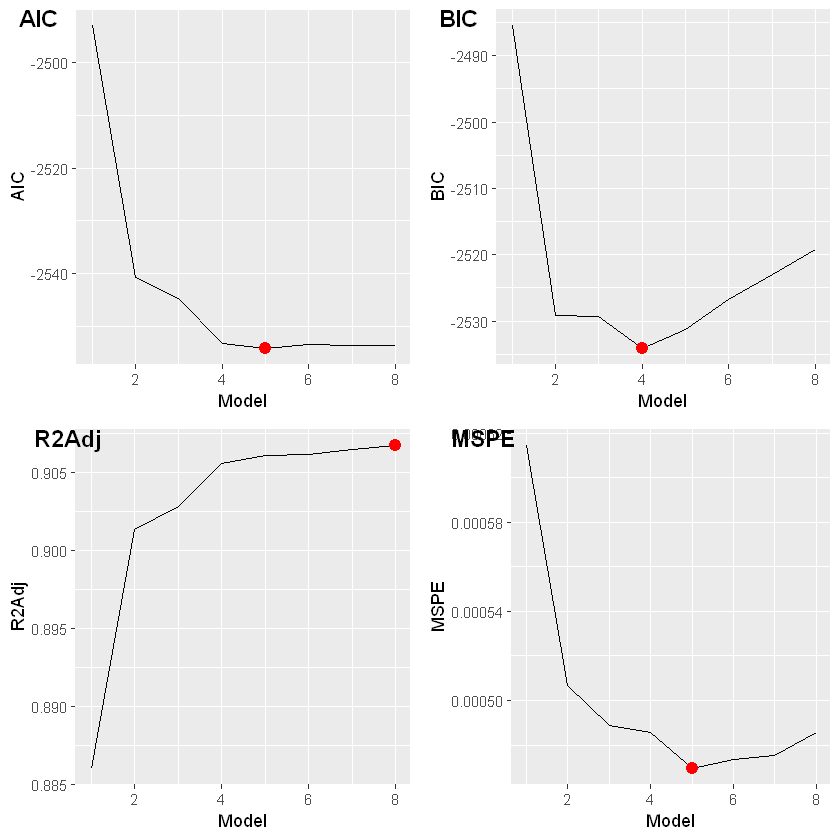

In [29]:
# recent data - winning percentage (WP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_recent_mlr, train_set=train_recent, test_set=test_recent, response='WP', subset_type='Recent')

## Recent Dataset - WP

- AIC reports Model 5 as the best model (minimum)
- BIC reports Model 4 as the best model (minimum)
- $R^2_a$ reports model 8 as the best model (maximum)
- MSPE reports model 5 as the best model

We have three metrics alluding to Model 5 being the best model to describe the response, and the metrics that don't allude to this being the best, their best are relatively close for Model 5 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 5 as our best model, with the features:

- SLG
- RD
- OOBP
- Playoffs
- Champion

In [40]:
lmod <- lm(data=train_recent, WP~.)
lmod_recent_wp <- lm(data=train_recent, WP~SLG+RD+OOBP+Playoffs+Champion)
summary(lmod_recent_wp)
anova(lmod_recent_wp, lmod)


Call:
lm(formula = WP ~ SLG + RD + OOBP + Playoffs + Champion, data = train_recent)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.059788 -0.015633 -0.000087  0.014128  0.063779 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.840e-01  3.358e-02  17.392  < 2e-16 ***
SLG          2.492e-01  7.978e-02   3.124  0.00194 ** 
RD           4.632e-04  2.593e-05  17.865  < 2e-16 ***
OOBP        -5.891e-01  1.495e-01  -3.941 9.91e-05 ***
Playoffs     2.489e-02  3.621e-03   6.876 3.10e-11 ***
Champion     1.175e-02  6.960e-03   1.688  0.09242 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02216 on 330 degrees of freedom
Multiple R-squared:  0.9075,	Adjusted R-squared:  0.9061 
F-statistic: 647.2 on 5 and 330 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,330,0.1620059,NA,NA,NA,NA
2,327,0.1594018,3,0.0026041,1.780701,0.1506477


*Note: Model 3 does pass as a sufficient reduced model.*

*Note: Model 3 passes the full F-test.*

  (Intercept)   SLG   BA    WP    RD  OOBP  OSLG Playoffs Champion
1        TRUE FALSE TRUE FALSE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE  TRUE TRUE FALSE FALSE FALSE FALSE    FALSE    FALSE
3        TRUE FALSE TRUE FALSE  TRUE  TRUE FALSE    FALSE    FALSE
4        TRUE FALSE TRUE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
5        TRUE FALSE TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
6        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
7        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE     TRUE    FALSE
8        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


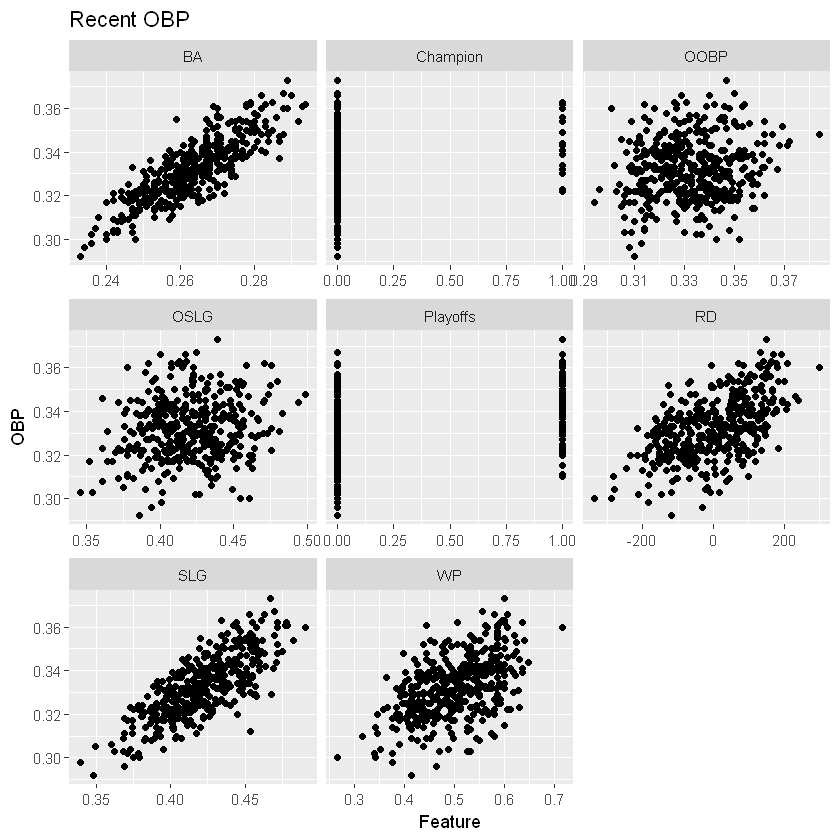

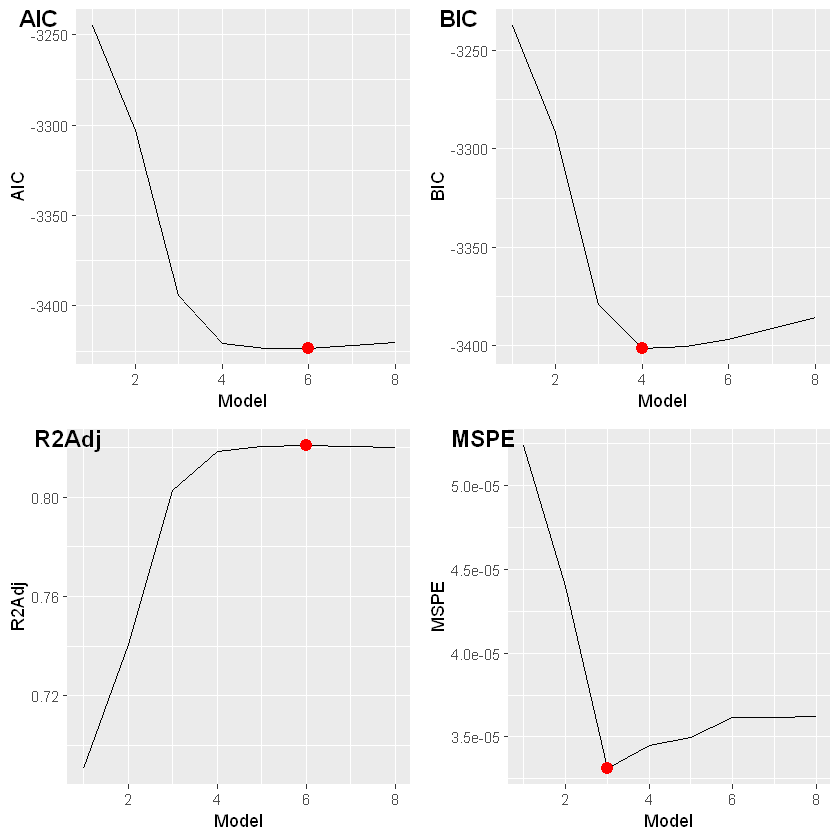

In [30]:
# recent data - on-base percentage (OBP)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_recent_mlr, train_set=train_recent, test_set=test_recent, response='OBP', subset_type='Recent')

## Recent Dataset - OBP

- AIC reports Model 6 as the best model (minimum)
- BIC reports Model 4 as the best model (minimum)
- $R^2_a$ reports model 6 as the best model (maximum)
- MSPE reports model 3 as the best model

We have three metrics alluding to Model 3 being the best model to describe the response, and the metrics that don't allude to this being the best, their best are relatively close for Model 3 as well. However, we should use a partial F-test to confirm the model is sufficient.

Therefore, it's reasonable to use Model 3 as our best model, with the features:

- BA
- RD
- OOBP

> Model 3 does not pass the partial F-test, let's try Model 4.

- BA
- RD
- OOBP
- OSLG

In [43]:
lmod <- lm(data=train_recent, OBP~.)
lmod_recent_obp <- lm(data=train_recent, OBP~BA+RD+OOBP)
summary(lmod_recent_obp)
anova(lmod_recent_obp, lmod)


Call:
lm(formula = OBP ~ BA + RD + OOBP, data = train_recent)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0167828 -0.0041098 -0.0004499  0.0043506  0.0169850 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.628e-02  1.003e-02   4.613 5.68e-06 ***
BA          5.861e-01  4.307e-02  13.607  < 2e-16 ***
RD          8.079e-05  5.856e-06  13.797  < 2e-16 ***
OOBP        3.958e-01  3.829e-02  10.336  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.006367 on 332 degrees of freedom
Multiple R-squared:  0.8046,	Adjusted R-squared:  0.8028 
F-statistic: 455.6 on 3 and 332 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,332,0.01345979,NA,NA,NA,NA
2,327,0.01208833,5,0.001371462,7.41985,1.310247e-06


In [44]:
lmod <- lm(data=train_recent, OBP~.)
lmod_recent_obp <- lm(data=train_recent, OBP~BA+RD+OOBP+OSLG)
summary(lmod_recent_obp)
anova(lmod_recent_obp, lmod)


Call:
lm(formula = OBP ~ BA + RD + OOBP + OSLG, data = train_recent)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0170899 -0.0039947 -0.0002133  0.0039228  0.0165537 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.558e-02  9.784e-03   5.681 2.94e-08 ***
BA          5.060e-01  4.392e-02  11.521  < 2e-16 ***
RD          9.179e-05  5.978e-06  15.355  < 2e-16 ***
OOBP        2.659e-01  4.391e-02   6.055 3.82e-09 ***
OSLG        1.309e-01  2.421e-02   5.408 1.22e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.006113 on 331 degrees of freedom
Multiple R-squared:  0.8204,	Adjusted R-squared:  0.8183 
F-statistic: 378.1 on 4 and 331 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,331,0.01236711,NA,NA,NA,NA
2,327,0.01208833,4,0.0002787801,1.885312,0.1126689


*Note: Model 4 does pass as a sufficient reduced model, and has a higher $R^2_a$ than Model 3 as well.*

*Note: Model 4 passes the full F-test.*

  (Intercept)   OBP    BA    WP    RD  OOBP  OSLG Playoffs Champion
1        TRUE  TRUE FALSE FALSE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE    FALSE    FALSE
3        TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
4        TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
5        TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
6        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
7        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE     TRUE    FALSE
8        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


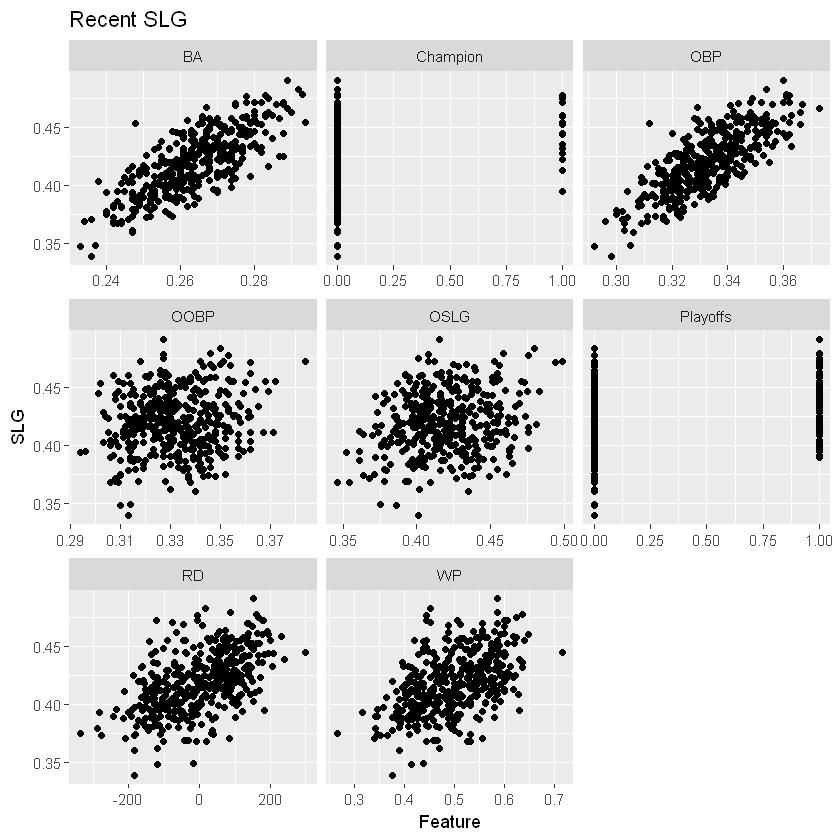

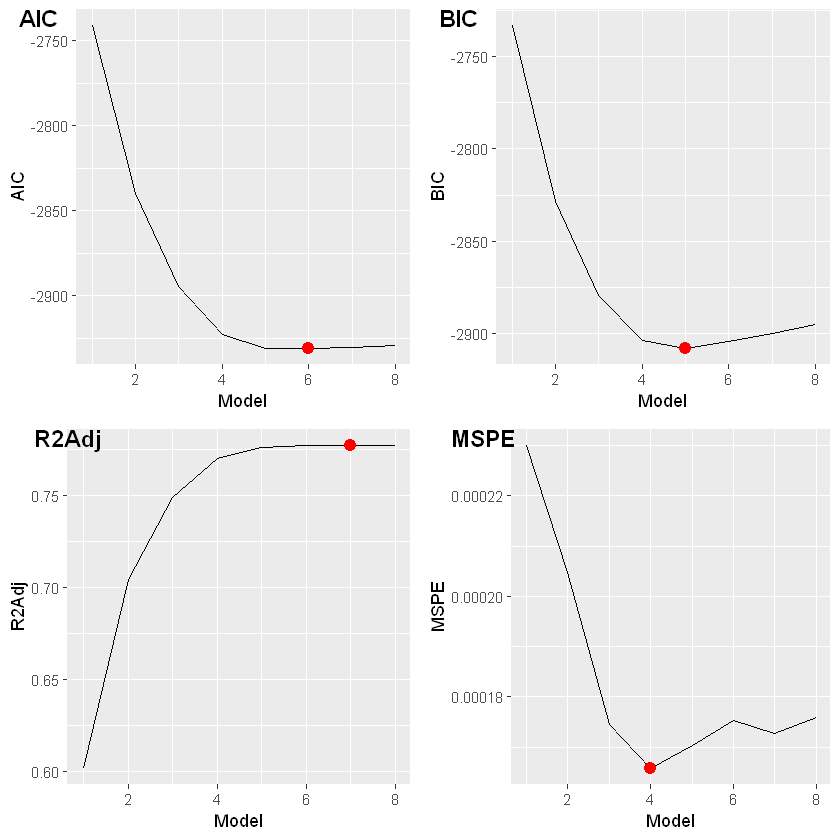

In [31]:
# recent data - slugging percentage (SLG)
# full_set, train_set, test_set, response, subset_type
plot_mlr(full_set=df_recent_mlr, train_set=train_recent, test_set=test_recent, response='SLG', subset_type='Recent')

## Recent Dataset - SLG

- AIC reports Model 6 as the best model (minimum)
- BIC reports Model 5 as the best model (minimum)
- $R^2_a$ reports model 7 as the best model (maximum)
- MSPE reports model 4 as the best model

Our metrics are inconclusive as they all allude to different models being the best model. However, let's begin with the simplest model and see if it is sufficient to describe the response through the partial F-test.

Therefore, it's reasonable to use Model 4 as our best model, with the features:

- BA
- RD
- OOBP
- OSLG

> Model 4 does not pass the partial F-test, let's try Model 5.

- BA
- WP
- RD
- OOBP
- OSLG

In [45]:
lmod <- lm(data=train_recent, SLG~.)
lmod_recent_slg <- lm(data=train_recent, SLG~BA+RD+OOBP+OSLG)
summary(lmod_recent_slg)
anova(lmod_recent_slg, lmod)


Call:
lm(formula = SLG ~ BA + RD + OOBP + OSLG, data = train_recent)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.037578 -0.008231 -0.001189  0.008668  0.046028 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.421e-02  2.052e-02  -3.130  0.00191 ** 
BA           5.165e-01  9.211e-02   5.608 4.32e-08 ***
RD           2.122e-04  1.254e-05  16.922  < 2e-16 ***
OOBP         5.330e-01  9.209e-02   5.788 1.65e-08 ***
OSLG         4.064e-01  5.077e-02   8.005 2.05e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01282 on 331 degrees of freedom
Multiple R-squared:  0.7729,	Adjusted R-squared:  0.7702 
F-statistic: 281.6 on 4 and 331 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,331,0.05439008,NA,NA,NA,NA
2,327,0.05209969,4,0.002290393,3.593872,0.006948259


In [46]:
lmod <- lm(data=train_recent, SLG~.)
lmod_recent_slg <- lm(data=train_recent, SLG~BA+WP+RD+OOBP+OSLG)
summary(lmod_recent_slg)
anova(lmod_recent_slg, lmod)


Call:
lm(formula = SLG ~ BA + WP + RD + OOBP + OSLG, data = train_recent)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.036203 -0.008514 -0.000989  0.007824  0.045195 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1170299  0.0262562  -4.457 1.14e-05 ***
BA           0.5048161  0.0909583   5.550 5.88e-08 ***
WP           0.0905859  0.0286744   3.159  0.00173 ** 
RD           0.0001593  0.0000208   7.661 2.07e-13 ***
OOBP         0.5714314  0.0916728   6.233 1.39e-09 ***
OSLG         0.4012907  0.0501229   8.006 2.04e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01265 on 330 degrees of freedom
Multiple R-squared:  0.7796,	Adjusted R-squared:  0.7762 
F-statistic: 233.4 on 5 and 330 DF,  p-value: < 2.2e-16


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,330,0.05279347,NA,NA,NA,NA
2,327,0.05209969,3,0.0006937836,1.451495,0.2277412


*Note: Model 5 does pass as a sufficient reduced model, and has a higher $R^2_a$ than Model 4 as well.*

*Note: Model 5 passes the full F-test.*

# Commentary

**The table printout:**

Each row represents a progressive combination of features, representing the best model of different sizes, with each row adding a new feature. The best models are determined by lowest SSE `SSE: formula_4`, or sum squared error.

**The Plots:**

The faceted plots show the relationship between the response and each feature used in the model, while the AIC, BIC `BIC: formula_2`, R2Adj `R2Adj: formula_5` ($R^2_a$) and MSPE plots are shown for aiding in model selection.

**F-test**

The full (or simultaneous) F-test `full-f-test: hypothesis_test_4` is helpful in preventing type I errors when selecting useful predictors in a multiple linear regression model.

In [47]:
print('Full Dataset - WP')
lmod_full_wp$coefficients
print('Full Dataset - OBP')
lmod_full_obp$coefficients
print('Full Dataset - SLG')
lmod_full_slg$coefficients
print('Recent Dataset - WP')
lmod_recent_wp$coefficients
print('Recent Dataset - OBP')
lmod_recent_obp$coefficients
print('Recent Dataset - SLG')
lmod_recent_slg$coefficients

[1] "Full Dataset - WP"


(Intercept)           RD     Playoffs     Champion 
0.4961244573 0.0006061088 0.0161423966 0.0083318303

[1] "Full Dataset - OBP"


(Intercept)         SLG          BA          WP 
 0.08560673  0.13366063  0.66755706  0.02931199

[1] "Full Dataset - SLG"


(Intercept)          OBP           BA     Playoffs 
-0.179198227  0.924648083  1.054280460  0.004932258

[1] "Recent Dataset - WP"


(Intercept)           SLG            RD          OOBP      Playoffs 
 0.5839715987  0.2492125550  0.0004632125 -0.5891186703  0.0248944150 
     Champion 
 0.0117465336

[1] "Recent Dataset - OBP"


(Intercept)           BA           RD         OOBP         OSLG 
5.558145e-02 5.060155e-01 9.179421e-05 2.658620e-01 1.309252e-01

[1] "Recent Dataset - SLG"


(Intercept)            BA            WP            RD          OOBP 
-0.1170298474  0.5048161096  0.0905859194  0.0001593308  0.5714313945 
         OSLG 
 0.4012906666

**WP**

- For the full dataset, we have: $y = 0.4961 + 0.0006 \text{ RD } + 0.0161 \text{ Playoffs } + 0.0083 \text{ Champion }$
- For the recent dataset, we have: $y = 0.5840 + 0.2492 \text{ SLG } + 0.0005 \text{ RD } - 0.05891 \text{ OOBP } + 0.0249 \text{ Playoffs } + 0.0117 \text{ Champion }$

**OBP**

- For the full dataset, we have: $y = 0.0856 + 0.1337 \text{ SLG } + 0.6676 \text{ BA } + 0.0293 \text{ WP }$
- For the recent dataset, we have: $y = 0.0556 0.5060 \text{ BA } 9.1794e-05 \text{ RD } 0.2659 \text{ OOBP } 0.1309 \text{ OSLG }$

**SLG**

- For the full dataset, we have: $y = 0.5840 + 0.9246 \text{ OBP } + 1.0543 \text{ BA } + 0.0049 \text{ Playoffs }$
- For the recent dataset, we have: $y = -0.1170 + 0.5048 \text{ BA } + 0.0906 \text{ WP } + 0.0002 \text{ RD } + 0.5714 \text{ OOBP } + 0.4013 \text{ OSLG }$

# Diagnostics

## Plots

- Residuals vs. Fitted (constant variance assumption)
- QQ-Plot (normality assumption)
- Residuals vs. Leverage (outliers)
- Predicted vs. Observed (linearity assumption)
- Successive Residual Plot (independence assumption)

## Hypothesis Tests

- Shapiro-Wilk Normality Test (normality assumption)
- Durbin-Watson Test (autocorrelation of residuals - independence assumption)

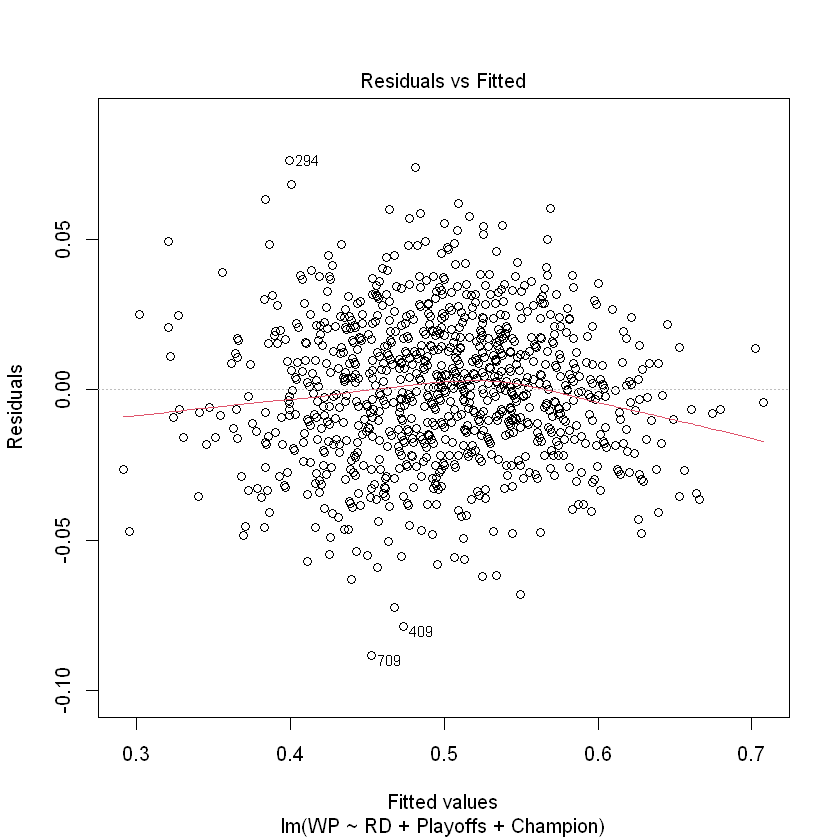

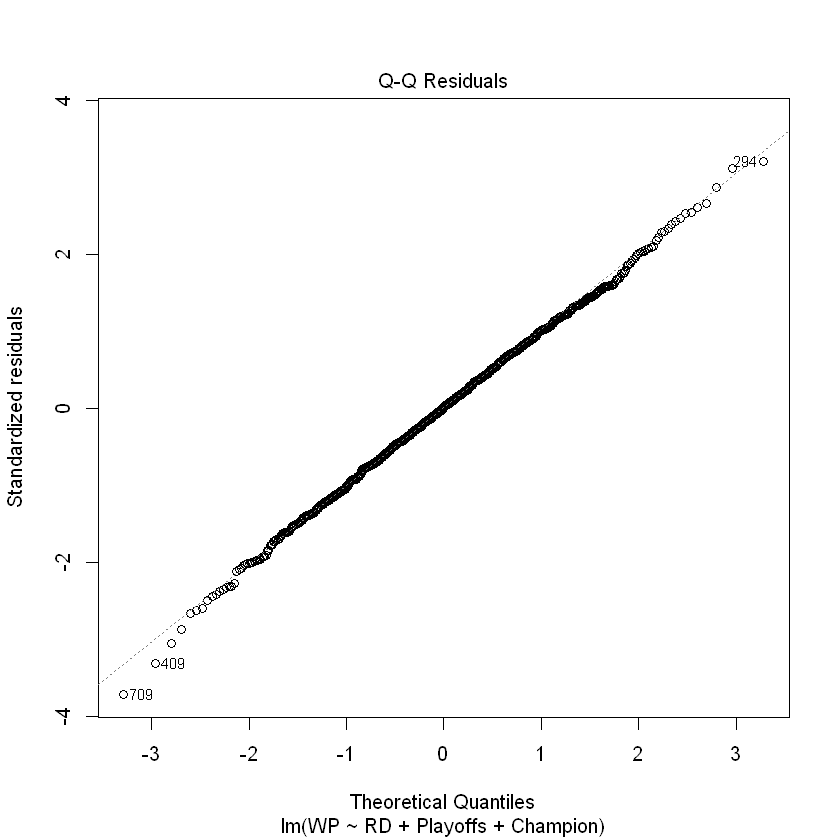

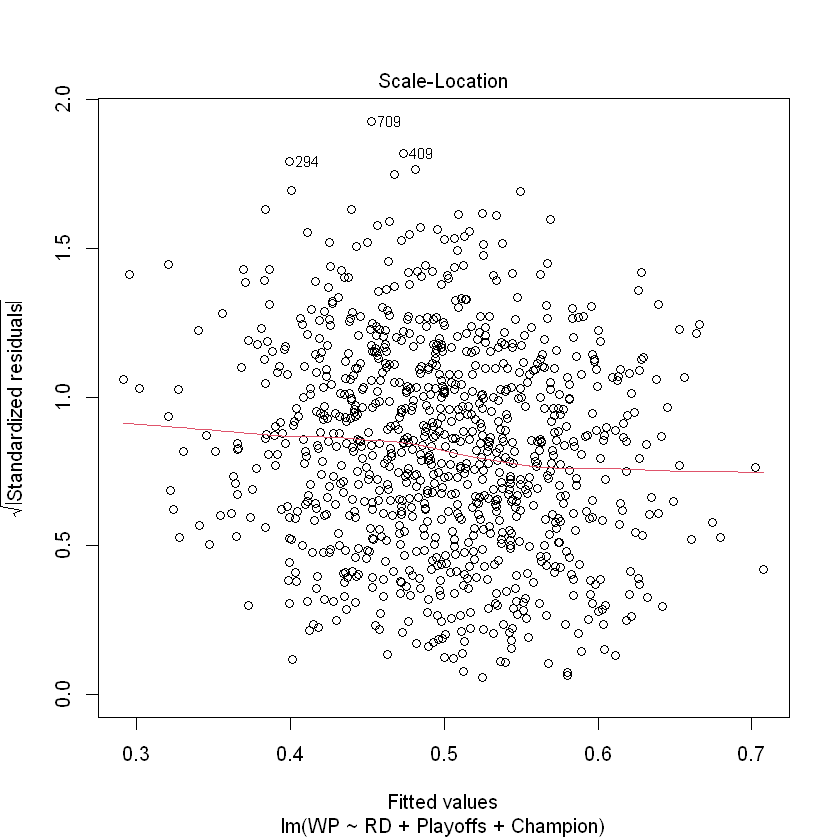

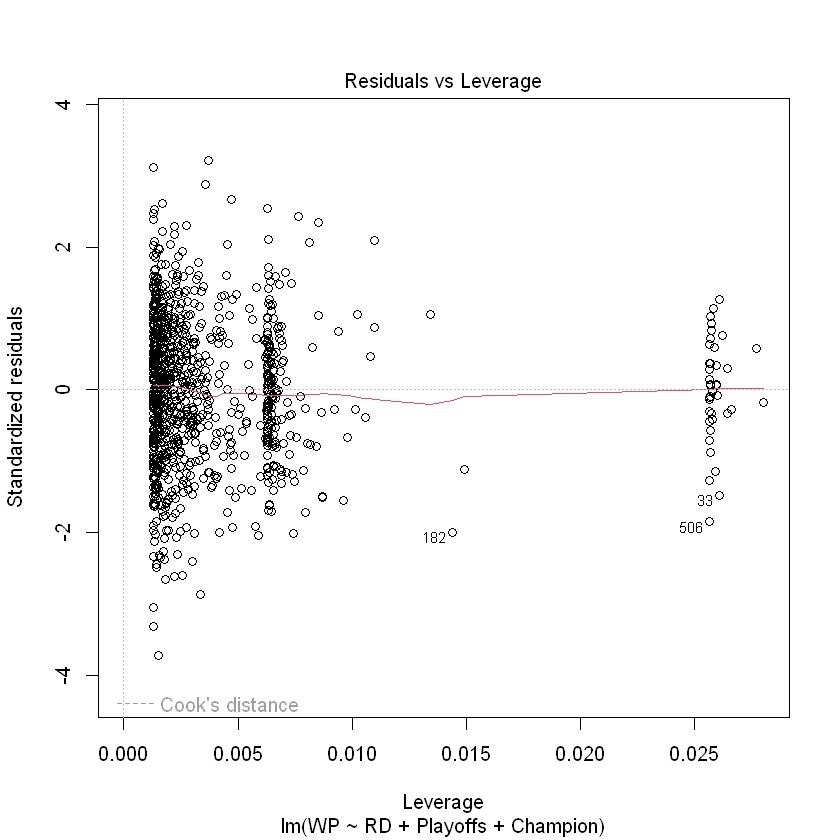

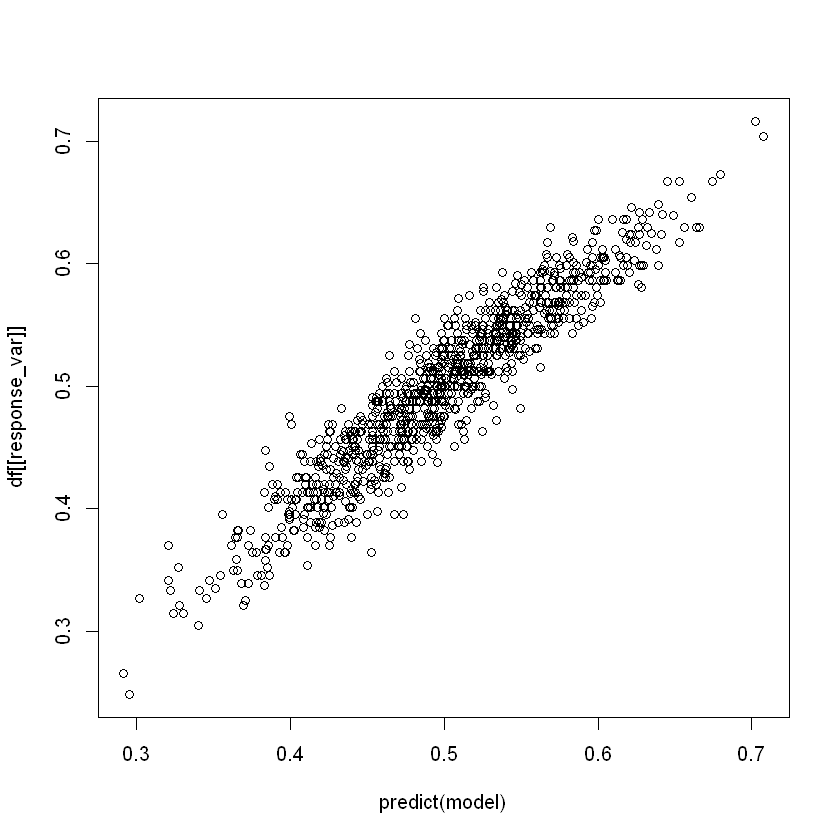

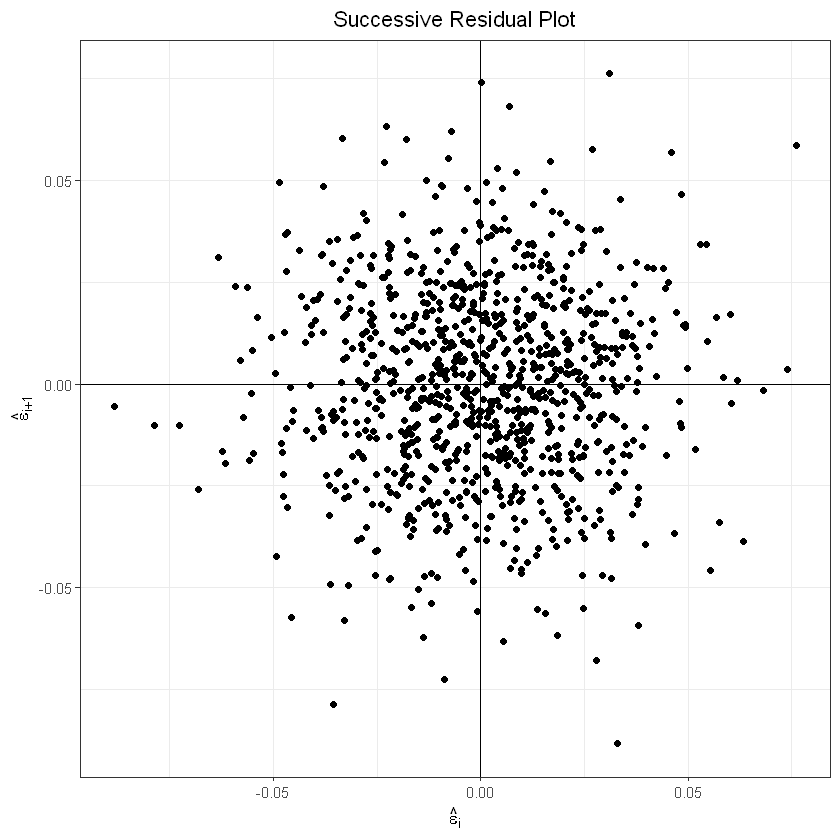

In [51]:
# full dataset - wp
diagnostics_plots(df=train_full, model=lmod_full_wp, response_var='WP', type='linear')

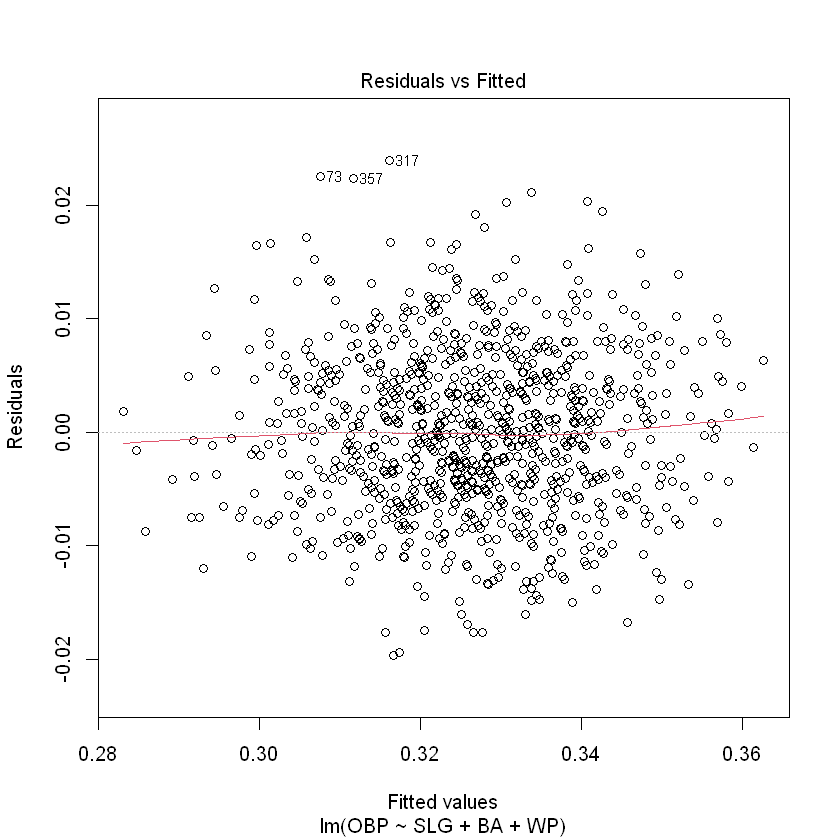

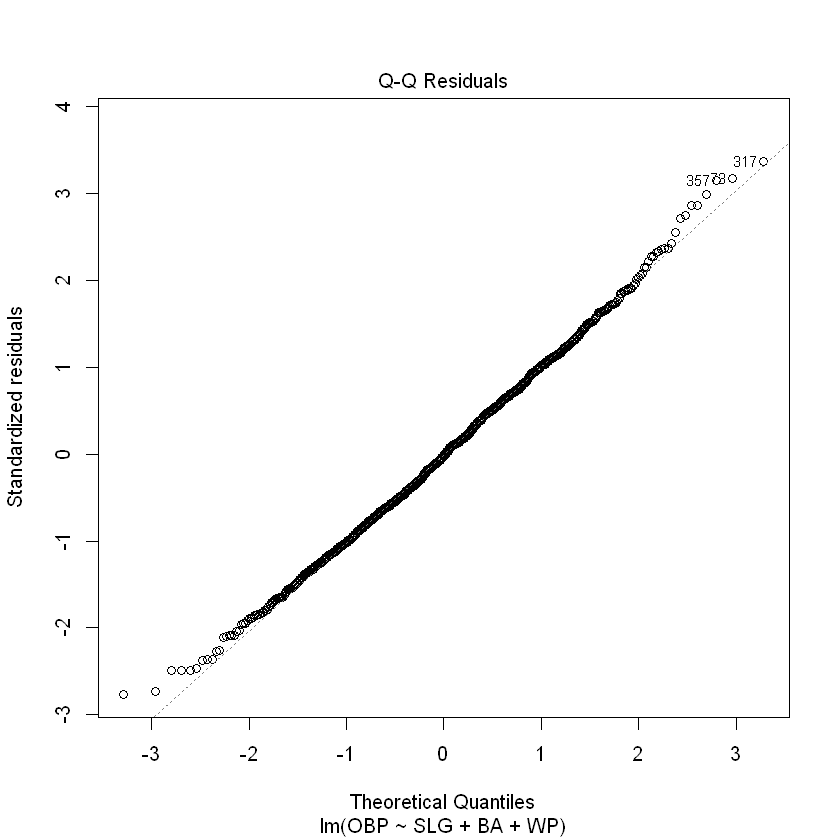

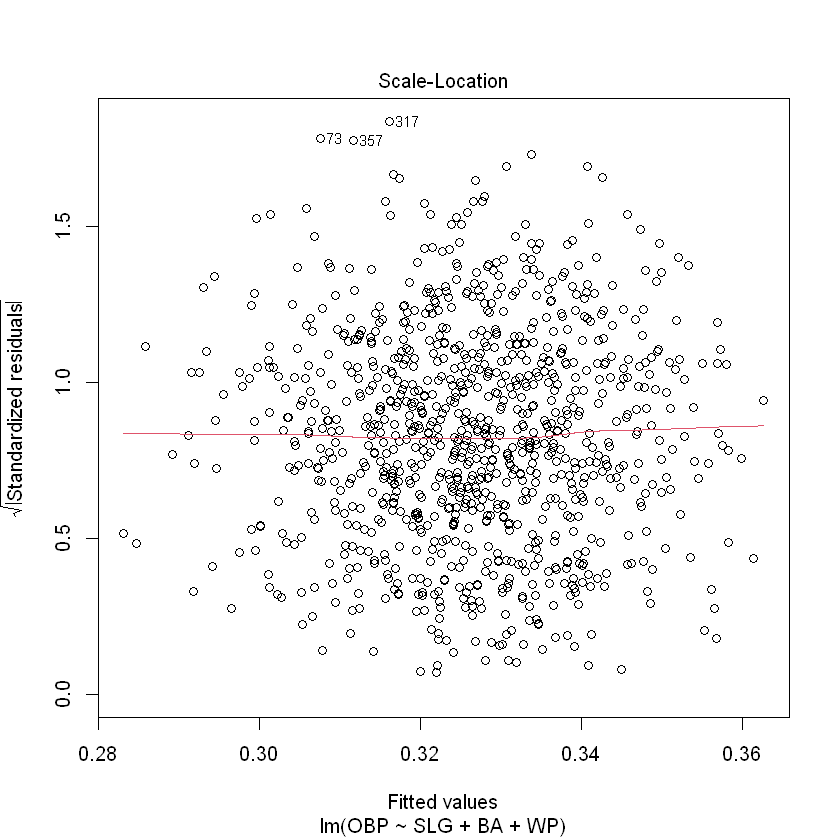

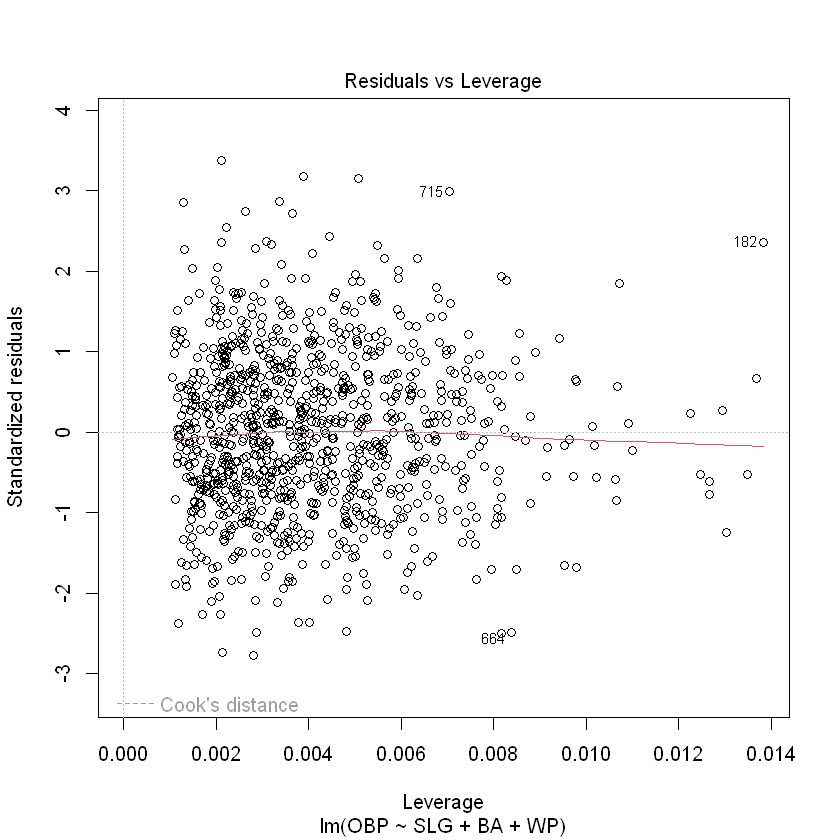

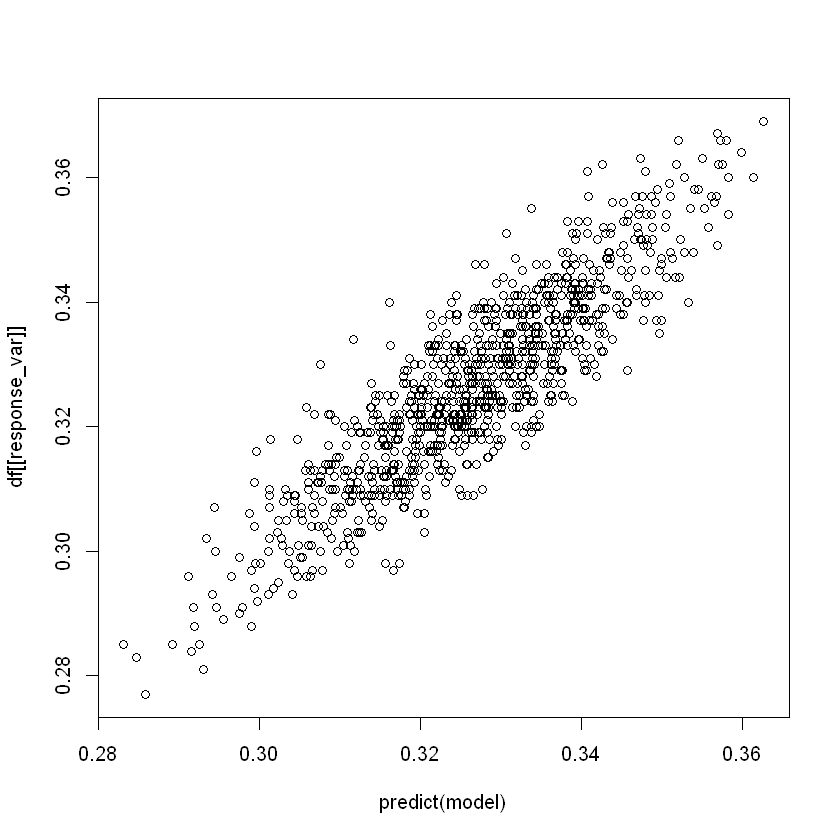

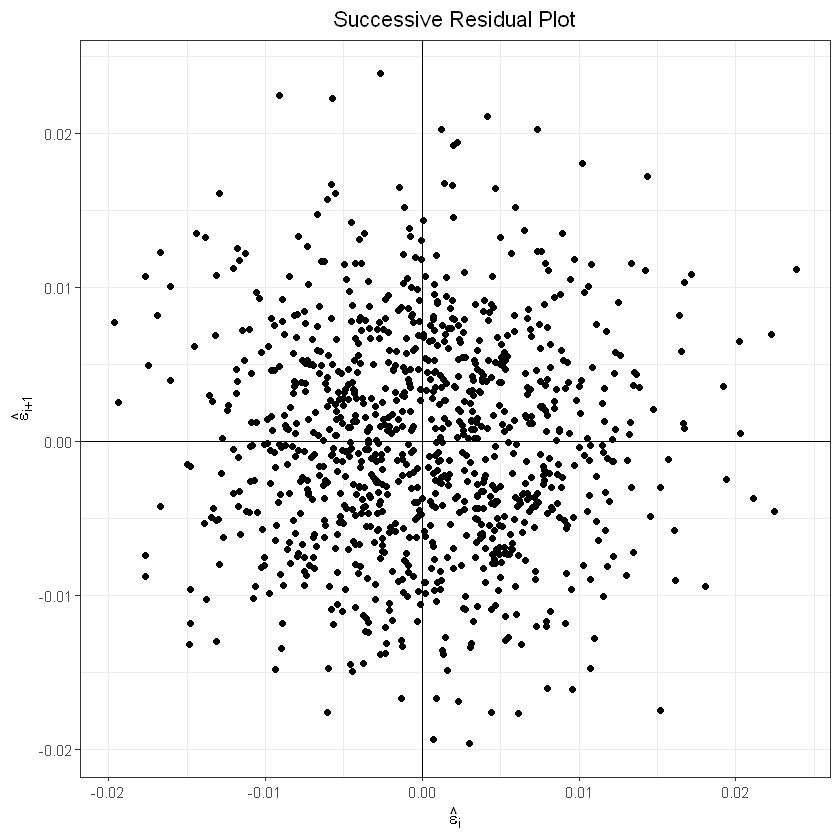

In [52]:
# full dataset - obp
diagnostics_plots(df=train_full, model=lmod_full_obp, response_var='OBP', type='linear')

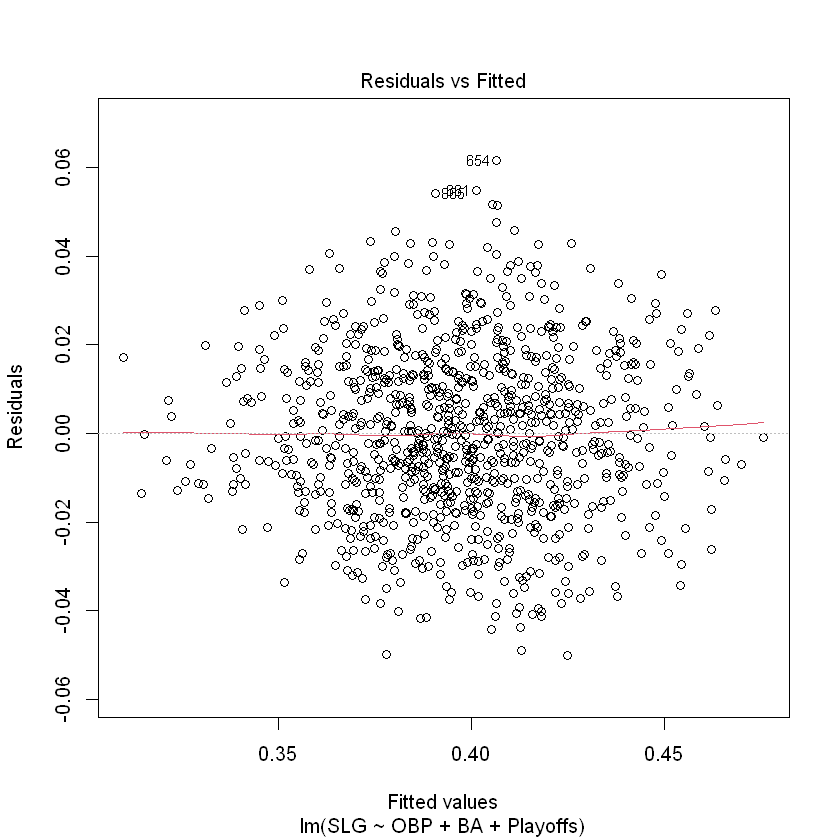

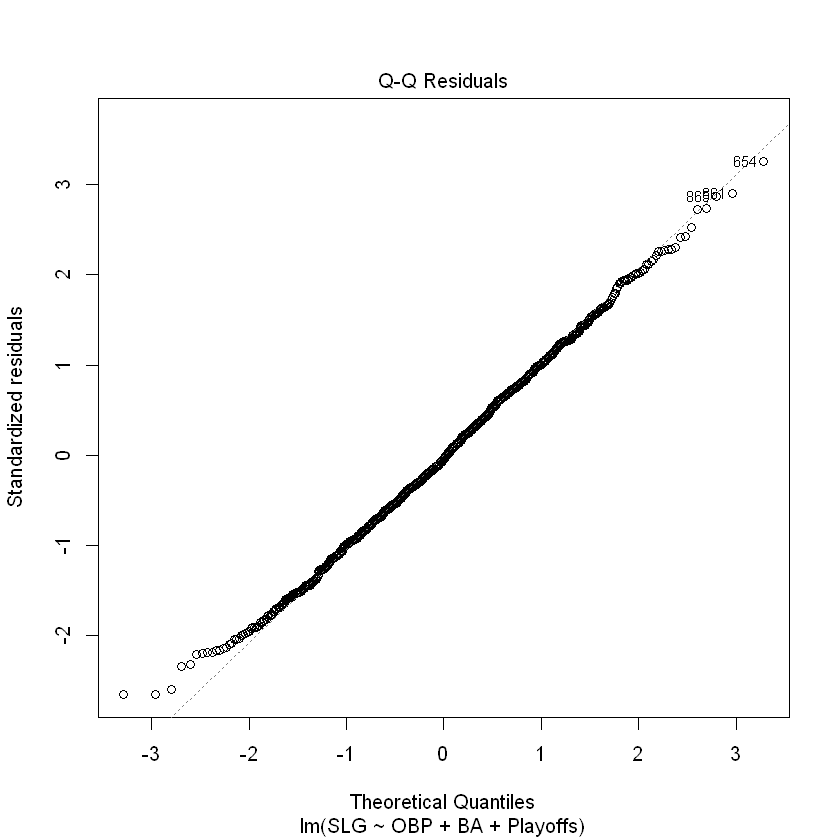

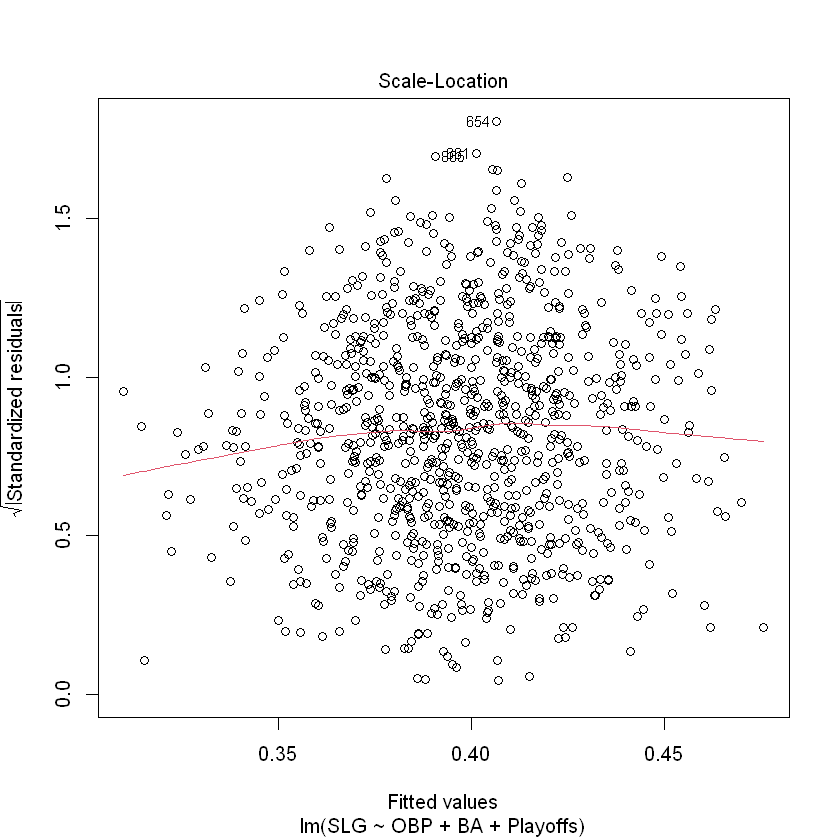

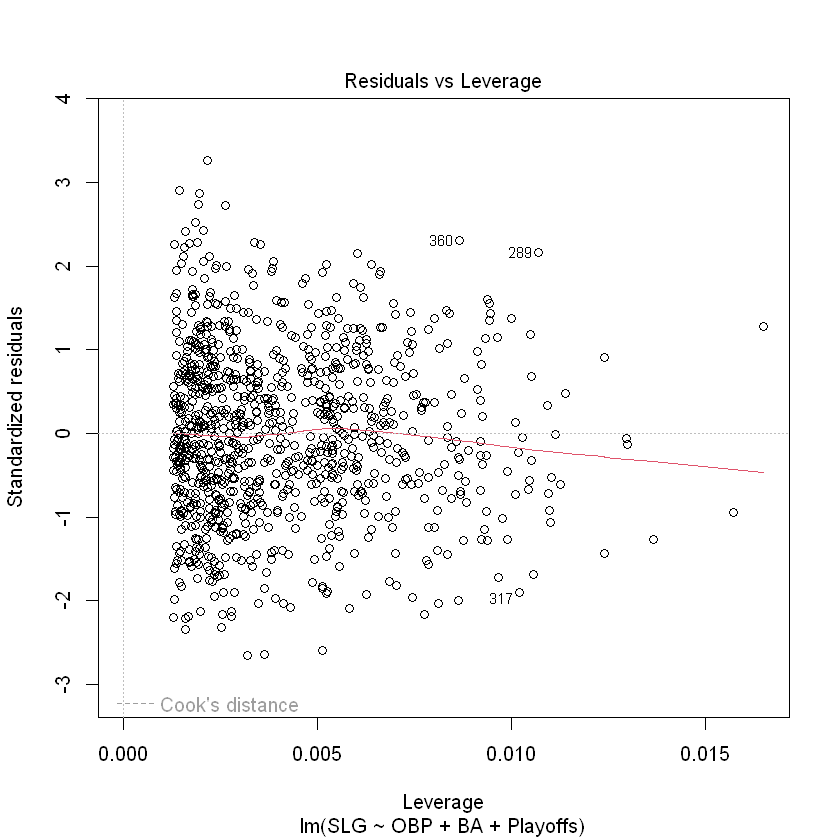

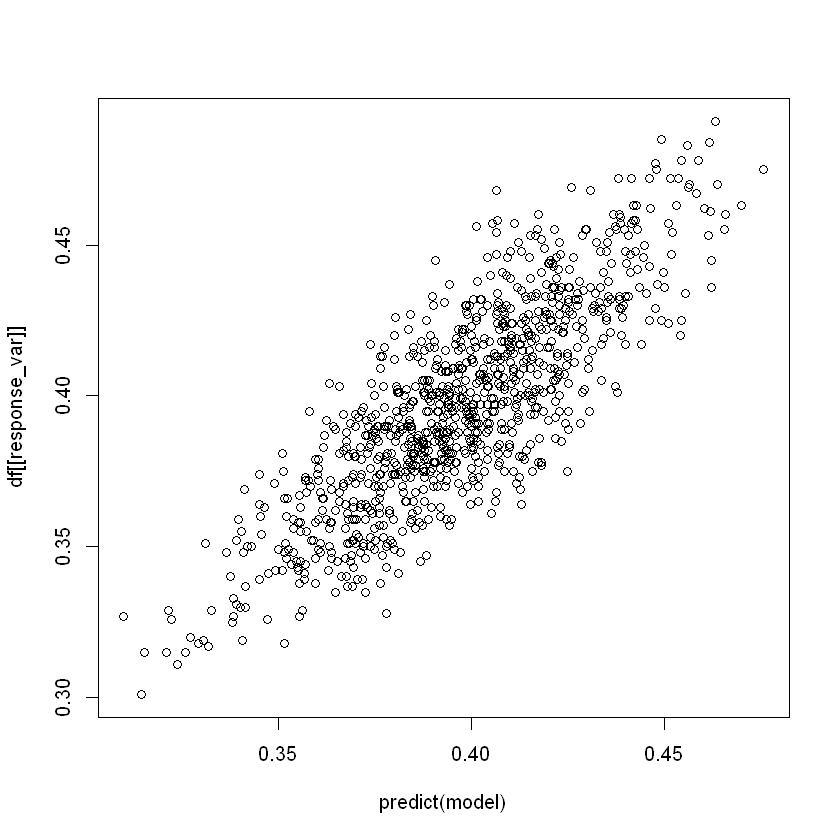

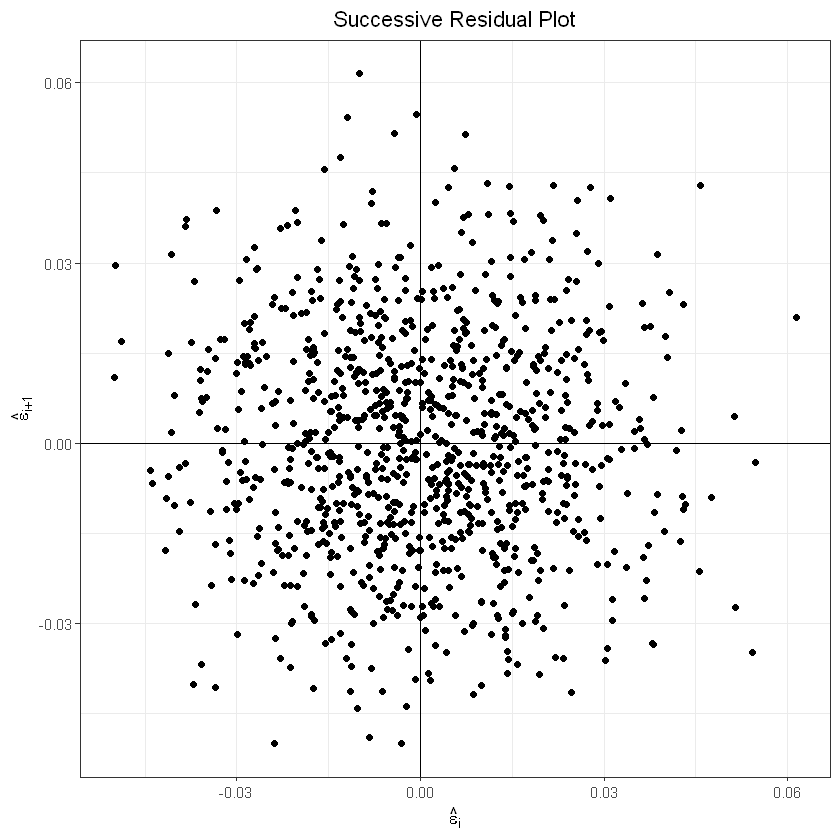

In [53]:
# full dataset - slg
diagnostics_plots(df=train_full, model=lmod_full_slg, response_var='SLG', type='linear')

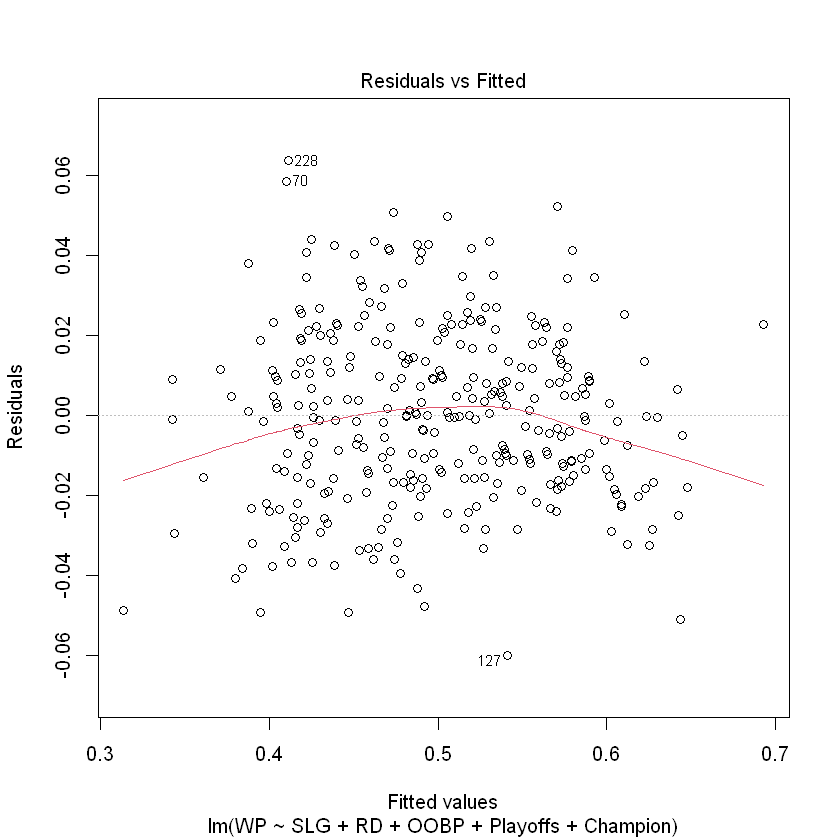

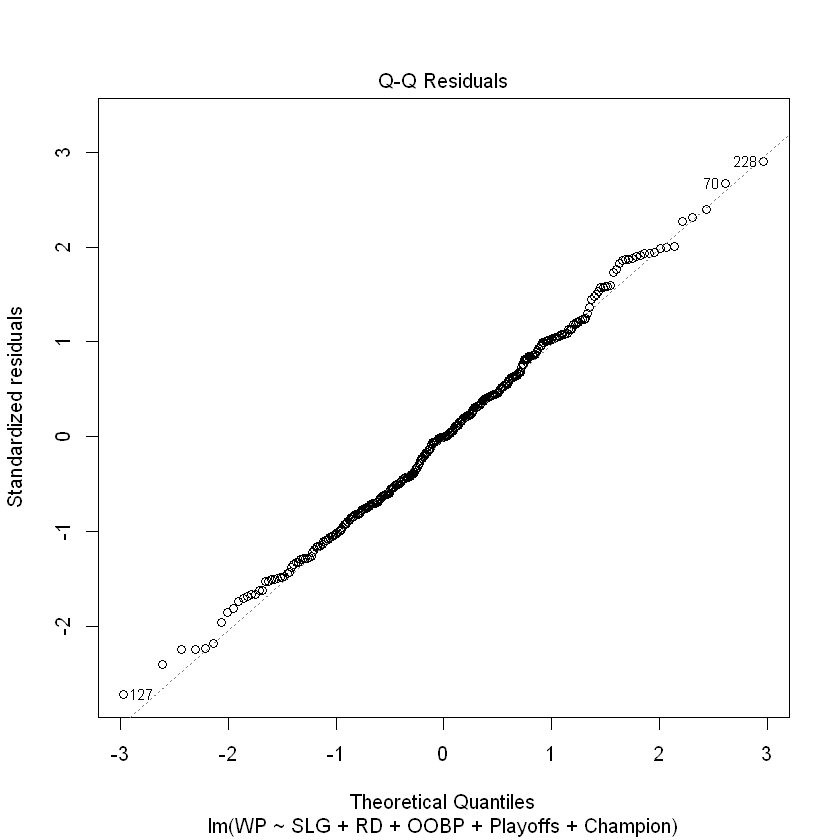

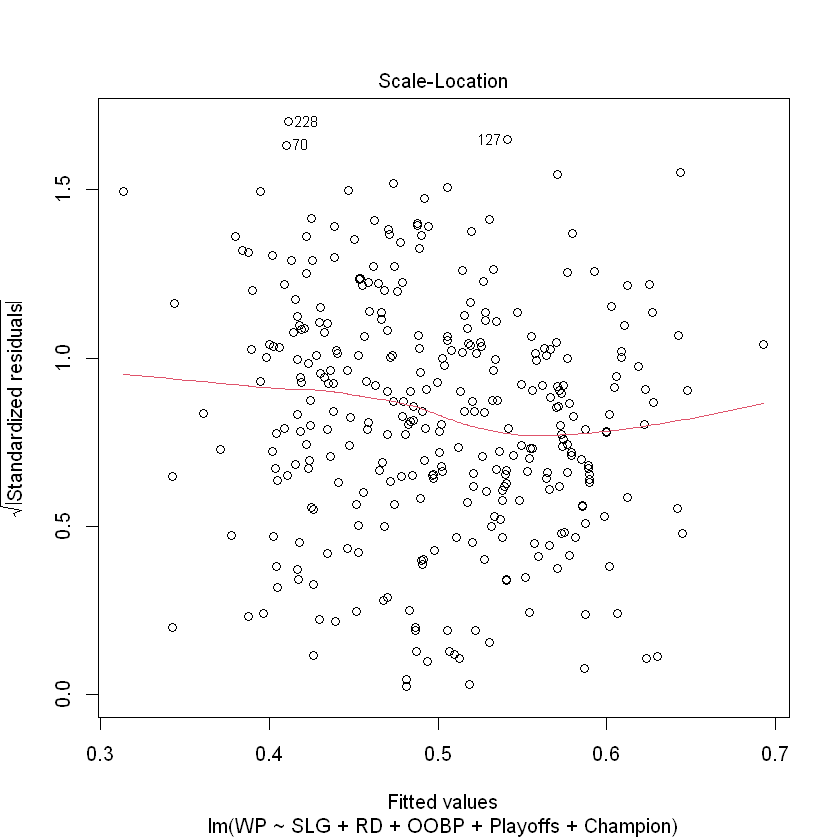

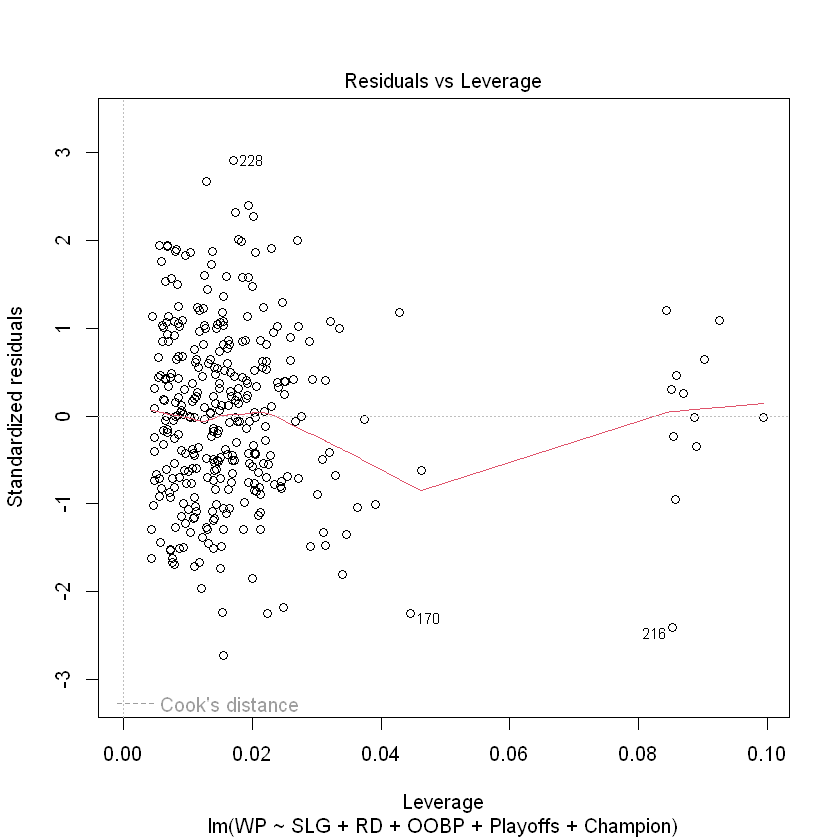

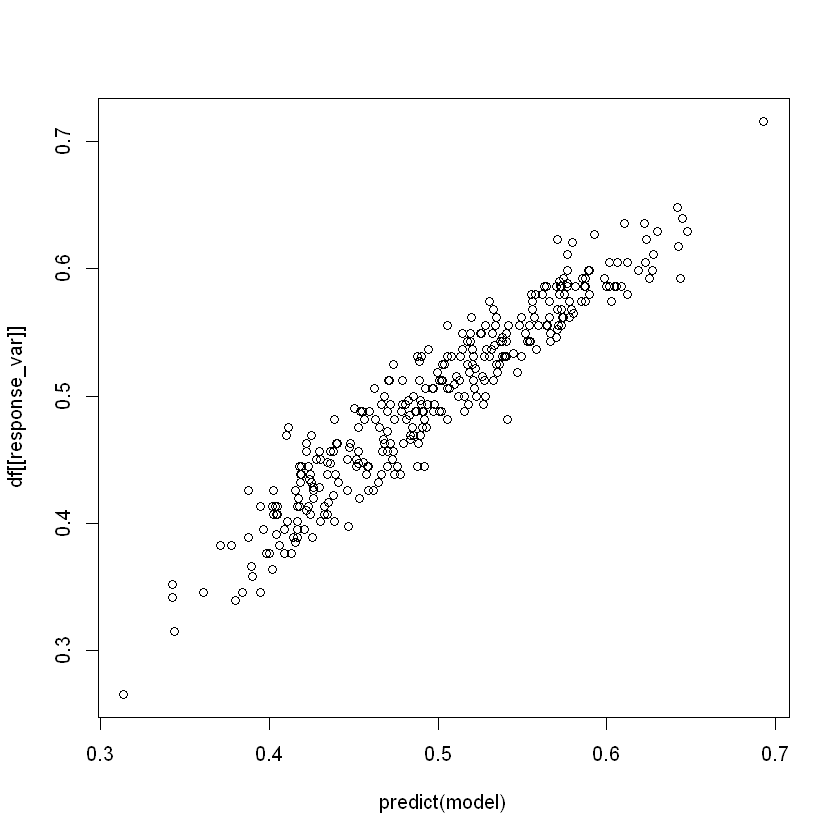

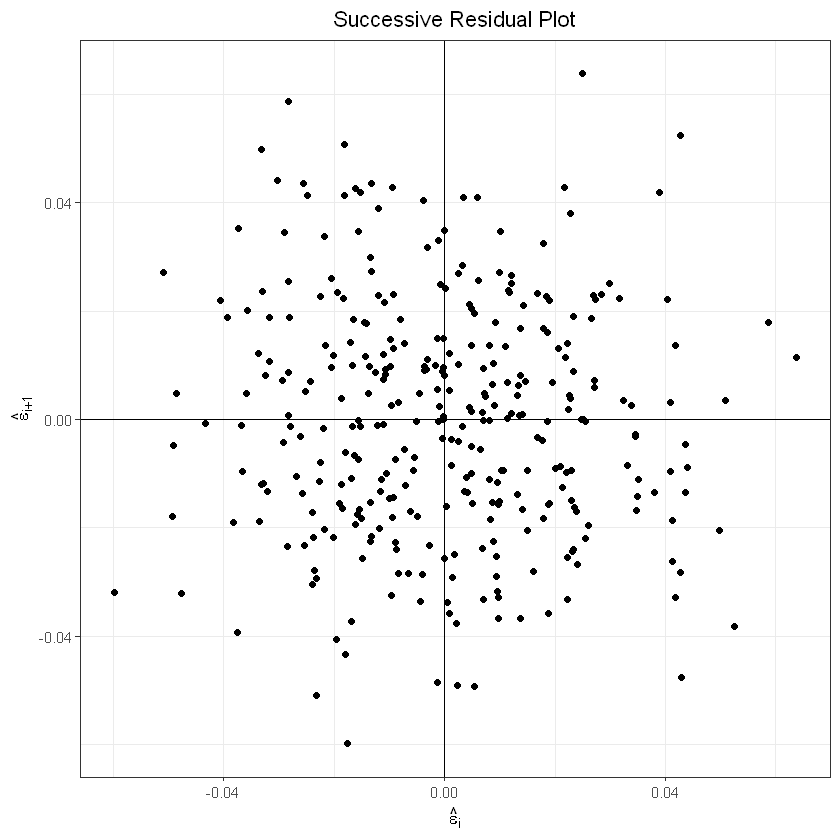

In [54]:
# recent dataset - wp
diagnostics_plots(df=train_recent, model=lmod_recent_wp, response_var='WP', type='linear')

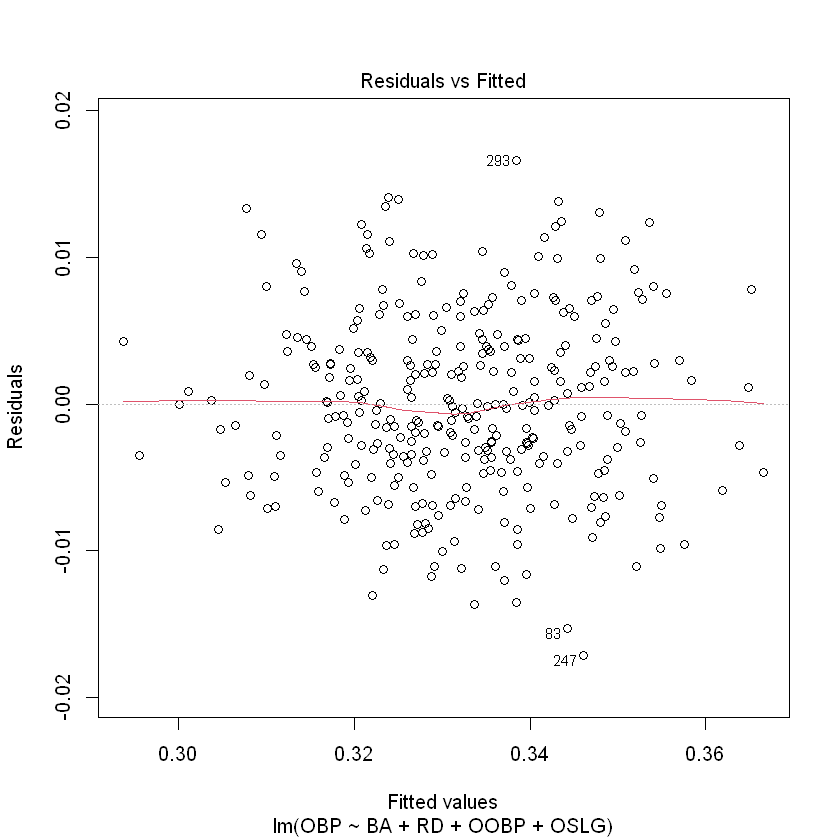

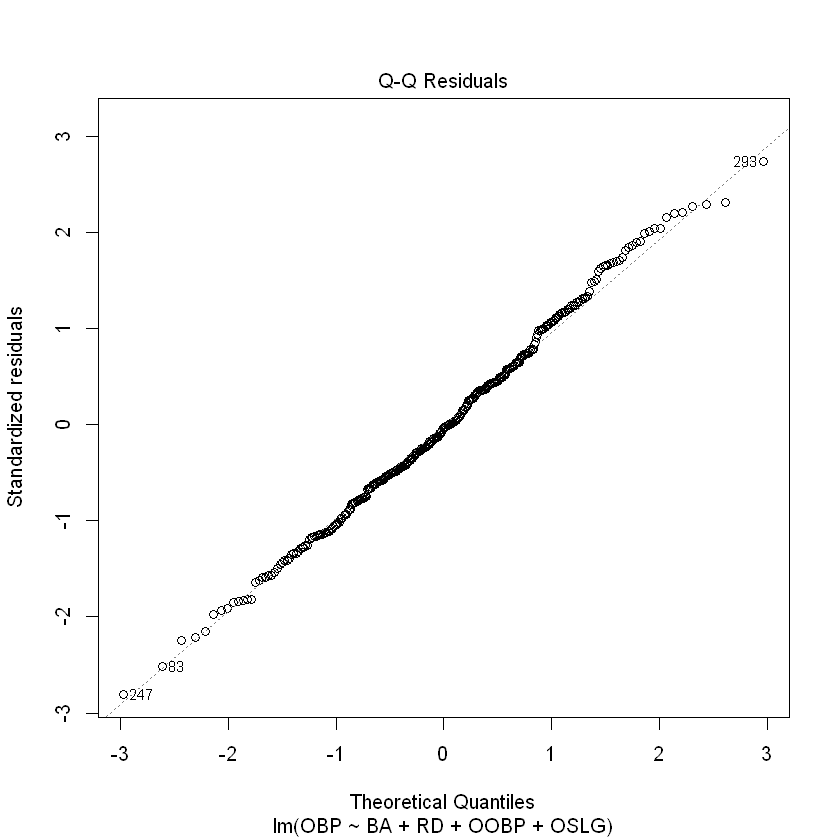

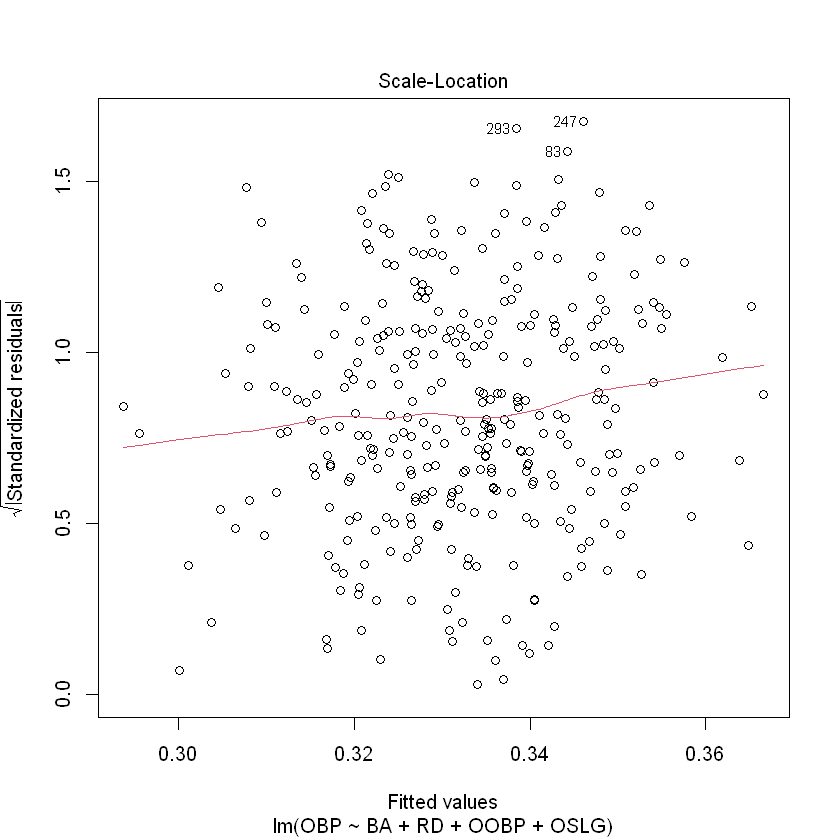

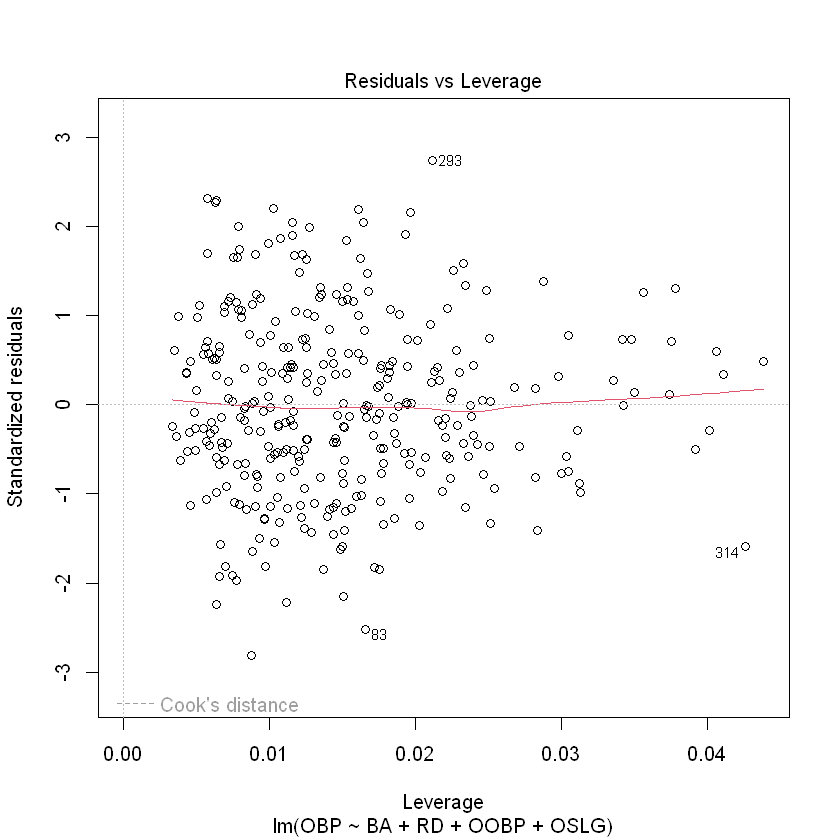

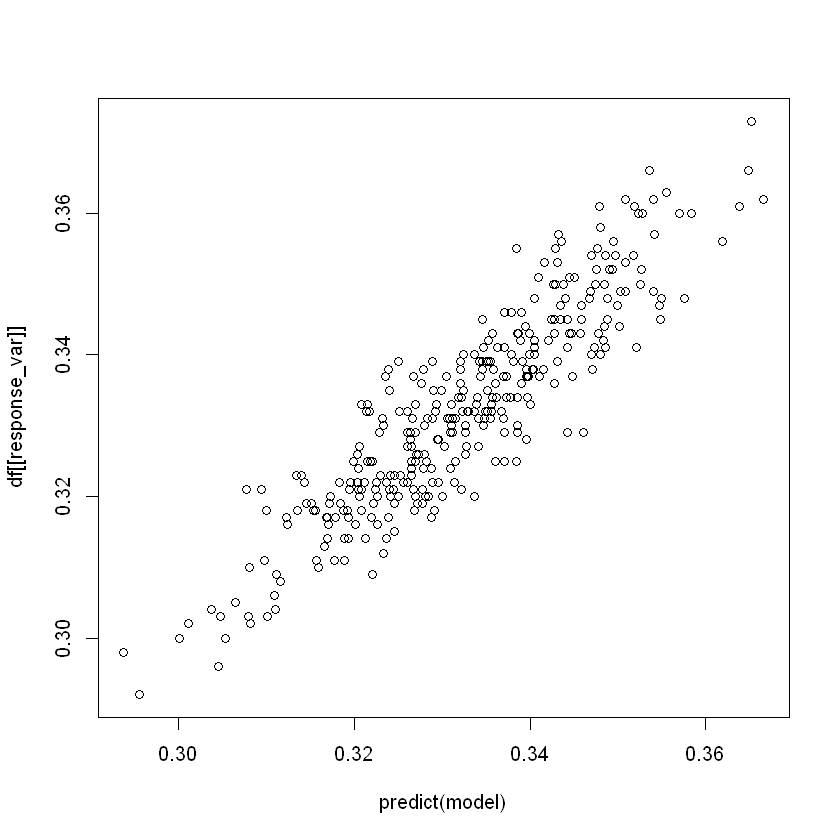

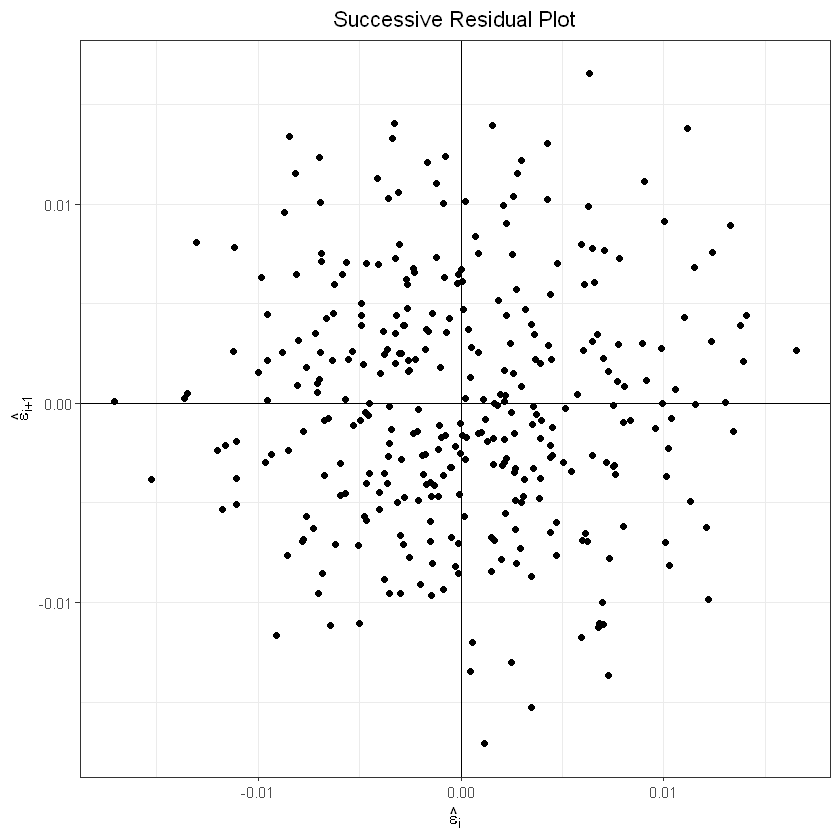

In [55]:
# recent dataset - obp
diagnostics_plots(df=train_recent, model=lmod_recent_obp, response_var='OBP', type='linear')

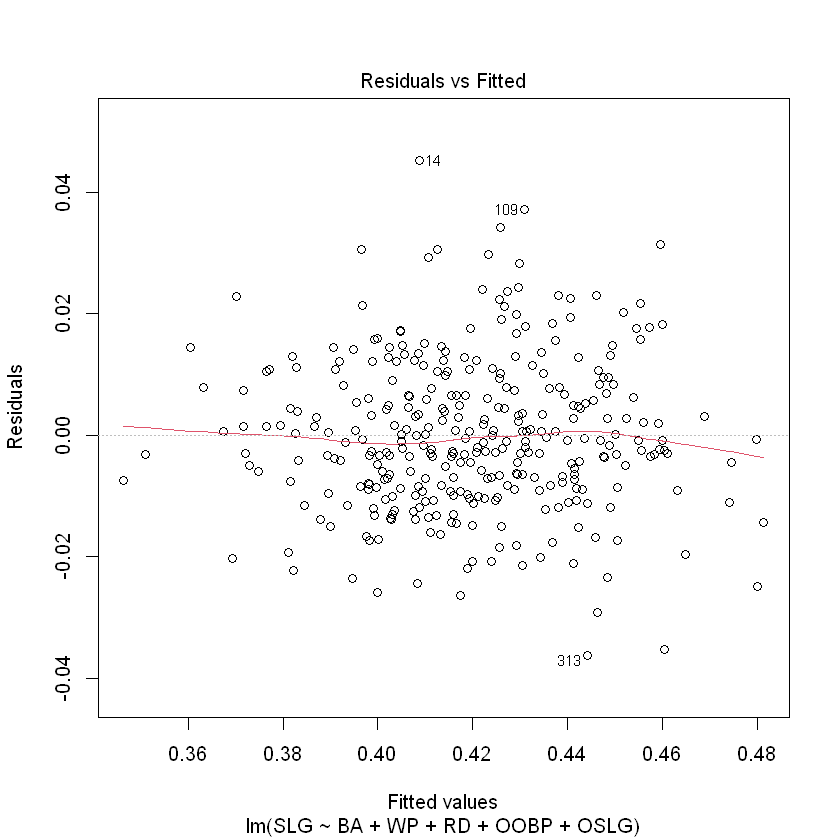

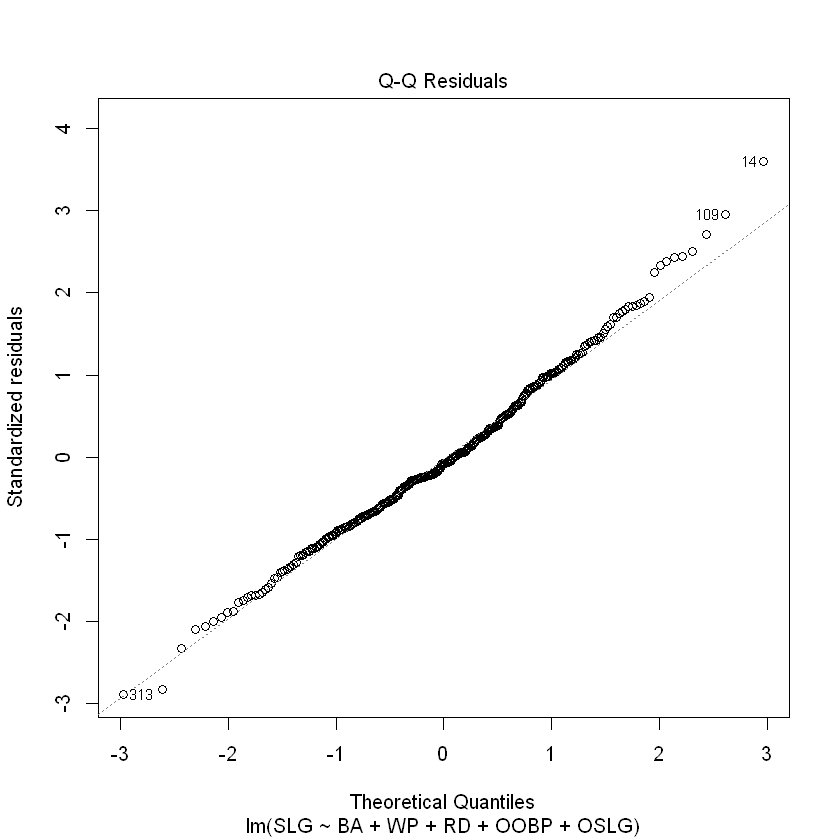

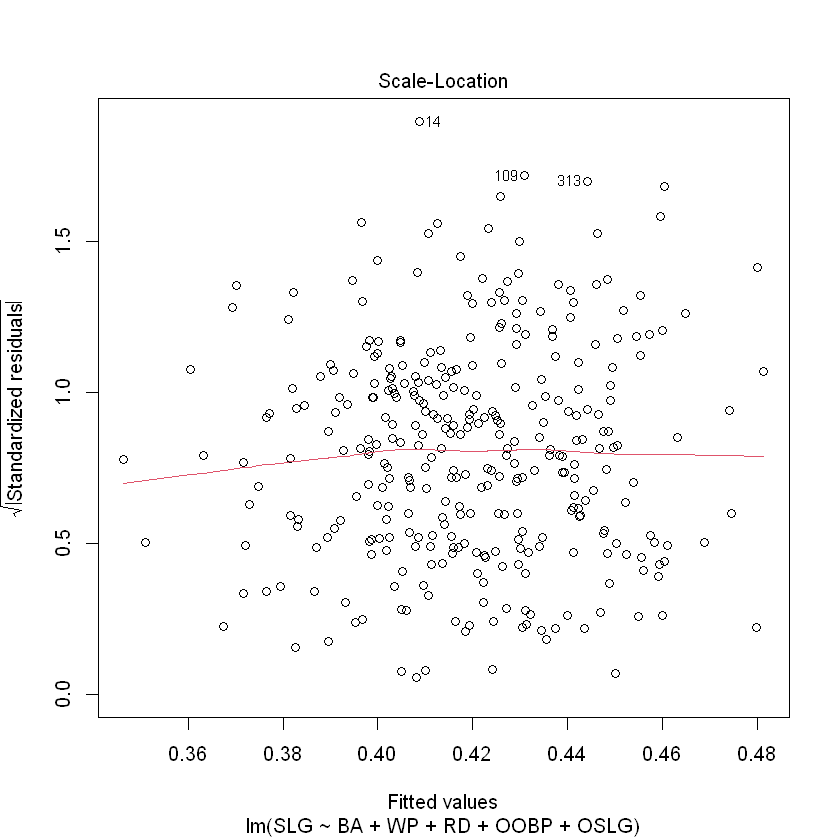

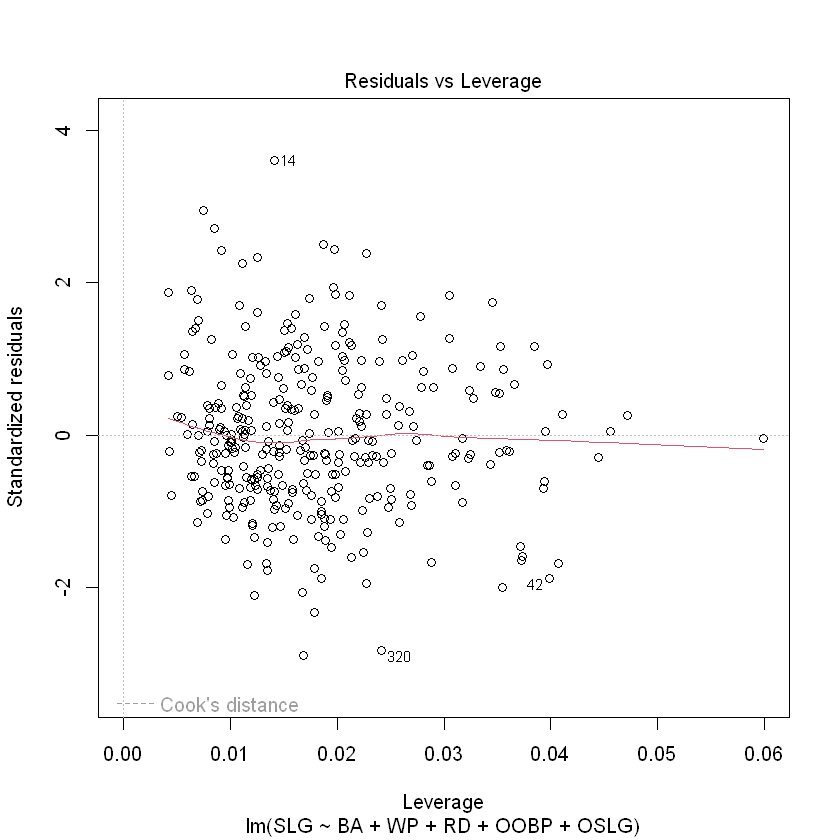

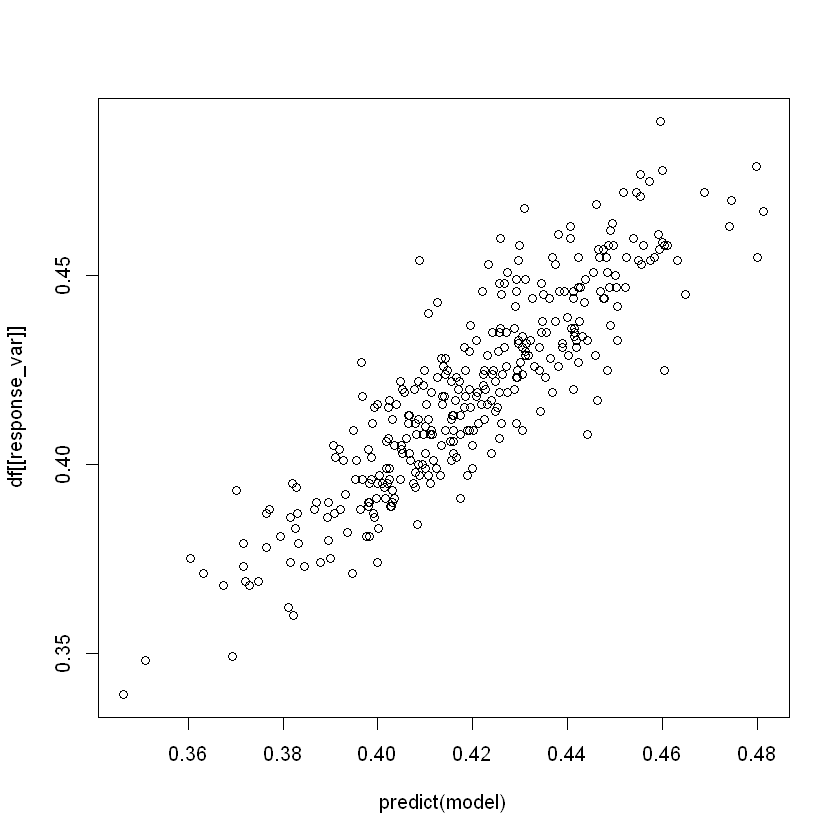

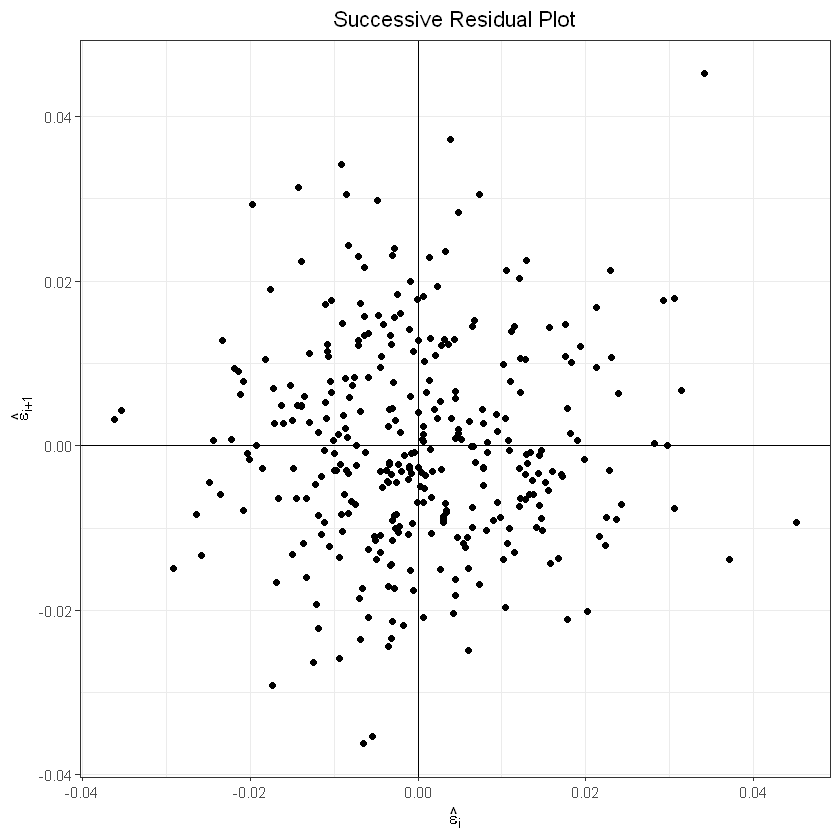

In [56]:
# recent dataset - slg
diagnostics_plots(df=train_recent, model=lmod_recent_slg, response_var='SLG', type='linear')

# Comments on Diagnostic Plots

# Collinearity

In [60]:
# full dataset - wp
print('Full Dataset - WP')
vif(lmod_full_wp)
# full dataset - obp
print('Full Dataset - OBP')
vif(lmod_full_obp)
# full dataset - slg
print('Full Dataset - SLG')
vif(lmod_full_slg)

# recent dataset - wp
print('Recent Dataset - WP')
vif(lmod_recent_wp)
# recent dataset - obp
print('Recent Dataset - OBP')
vif(lmod_recent_obp)
# recent dataset - slg
print('Recent Dataset - SLG')
vif(lmod_recent_slg)

[1] "Full Dataset - WP"


RD Playoffs Champion 
1.549468 1.616760 1.229093

[1] "Full Dataset - OBP"


SLG       BA       WP 
2.698308 2.718200 1.226786

[1] "Full Dataset - SLG"


OBP       BA Playoffs 
3.895711 3.693736 1.161660

[1] "Recent Dataset - WP"


SLG       RD     OOBP Playoffs Champion 
3.105195 5.554386 3.682427 1.759538 1.141900

[1] "Recent Dataset - OBP"


BA       RD     OOBP     OSLG 
2.429543 3.879635 4.174665 3.849793

[1] "Recent Dataset - SLG"


BA        WP        RD      OOBP      OSLG 
 2.433599  8.998001 10.966188  4.249479  3.853817

# Comments on Collinearity